# Построение прогнозных моделей для предсказания уровня удовлетворёности сотрудника работой и его увольнения

В ходе проекта работа ведётся над запросом HR-аналитиков компании «Работа с заботой». В целях оптимизации работы с персоналом поставлены две основные задачи, которые будут выполняться в отдельных частях последовательно:
1) на основе данных о сотрудниках разработать решение, которое позволит предсказать уровень их удовлетворённости работы;  
2) с помощью тех же данных и результатов первого этапа предсказать увольнение сотрудника.

Для решения каждой из поставленных задач строится предсказательная модель, анализируются её результаты и интерпретируется влияние предикторов на целевую переменную. Для обеих моделей задано значение метрики, служащее критерием успеха. Завершает работу вывод с подведением итогов и возможными советами для бизнеса на основе интерпретации итоговых моделей.


# Оглавление:
---------------------------

1. [Предсказание уровня удовлетворённости сотрудника](#1)  
    1.1. [Загрузка библиотек и исходных данных](#1.1)  
    1.2. [Предобработка данных](#1.2)  
    1.3. [Исследовательский анализ данных](#1.3)  
    1.4. [Пайплайн с подготовкой данных и обучением моделей](#1.4)  
    1.5. [Интерпретация модели и предварительный вывод](#1.5)  
2. [Предсказание увольнения сотрудника из компании](#2)  
    2.1. [Загрузка библиотек и исходных данных](#2.1)  
    2.2. [Предобработка данных](#2.2)  
    2.3. [Исследовательский анализ данных](#2.3)  
    2.4. [Добавление нового входных признаков](#2.4)  
    2.5. [Пайплайн с подготовкой данных и обучением моделей](#2.5)  
    2.6. [Интерпретация модели и предварительный вывод](#2.6)  
3. [Общий вывод](#3)

<a name="1"></a>

## Предсказание уровня удовлетворённости сотрудника 

<a name="1.1"></a>

### Загрузка библиотек и исходных данных 

Загрузим нужные пакеты и установим необходимые библиотеки:

In [1]:
!pip install shap -q
!pip install phik -q
!pip install -Uq scikit-learn

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from pandas.api.types import is_integer_dtype
import phik

from sklearn.feature_selection import SelectKBest
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import Ridge, Lasso
from sklearn.dummy import DummyClassifier, DummyRegressor
import shap as shap

import pickle
import os
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

Считаем 3 датасета: с тренировочными данными, с входными признаками тестовых данных и с целевым признаком тестовых данных:

In [3]:
def check_and_read(path, index_col=None):
    if os.path.exists(path):
        return pd.read_csv(path, index_col=index_col)
    else:
        print(f'Не найден файл по указанному пути: {path}')

        
df = check_and_read('datasets/train_job_satisfaction_rate.csv', 'id')
df.info()
test_df = check_and_read('datasets/test_features.csv', 'id')
test_df.info()
y_df = check_and_read('datasets/test_target_job_satisfaction_rate.csv', 'id')
y_df.info()
display(df.head(10))
target1 = 'job_satisfaction_rate'

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   ob

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20
405448,hr,middle,low,7,no,no,4,30000,0.78
857135,sales,sinior,medium,9,no,no,3,56400,0.56
400657,purchasing,middle,high,9,no,no,3,52800,0.44
198846,hr,junior,low,1,no,no,2,13200,0.14


Заметим, что существуют пропуски в колонках с департаментом и уровнем должности сотрудника в тренировочном и тестовом наборах данных.

<a name="1.2"></a>

### Предобработка данных 

Посчитаем количество строк с пропусками в тренировочном наборе данных. Их удаление произведём в финальном пайплайне.

In [4]:
start_train = len(df)
start_test = len(test_df)
missing_train = missing_test = 0
display(df[(df['level'].isna()) | (df['dept'].isna())])
missing_train += len(df[(df['level'].isna()) | (df['dept'].isna())])
missing_train


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
631073,sales,NaN,medium,1,no,no,4,27600,0.66
416327,sales,NaN,low,1,no,no,5,18000,0.73
694746,NaN,junior,medium,5,no,no,4,21600,0.62
814624,NaN,junior,medium,3,no,no,4,24000,0.88
475114,NaN,junior,high,4,no,no,4,31200,0.63
135043,sales,NaN,medium,1,no,no,3,26400,0.30
998838,sales,NaN,medium,1,no,no,5,27600,0.71
497243,NaN,junior,medium,1,no,no,3,26400,0.28
168668,NaN,junior,low,3,no,no,4,18000,0.88


10

Аналогично посчитаем пропуски в тестовом датасете, их число равно 3:

In [5]:
print(test_df[test_df.isna().any(axis=1)])
missing_test += len(test_df[test_df.isna().any(axis=1)])

         dept   level workload  employment_years last_year_promo  \
id                                                                 
609865    NaN  junior   medium                 1              no   
471990  sales     NaN      low                 1              no   
832342    NaN  junior   medium                 1              no   

       last_year_violations  supervisor_evaluation  salary  
id                                                          
609865                   no                      1   20400  
471990                   no                      3   12000  
832342                   no                      4   28800  


Проверим датасет на наличие явных и неявных дубликатов, а также опечаток в наборах данных. Помимо опечаток, можно отметить битые строки в тестовом датасете. Эти значения будут заменены в рамках финального пайплайна. Наконец, были удалены дубликаты в тренировочном датасете. Общее количество пропусков и дубликатов составило порядка 6% для тренировочного набор данных и 28% для тестового: 

In [6]:
for name in df.select_dtypes('object').columns:
    print(name, df[name].unique())
df['level'].replace({'sinior':'senior'}, inplace=True)
print(df['level'].unique())
print(len(df[df.duplicated()]))
missing_train += len(df[df.duplicated()])
df.drop_duplicates(inplace=True)

for name in test_df.select_dtypes('object').columns:
    print(name, test_df[name].unique())
spaces = len(test_df[(test_df['dept']==' ') | (test_df['workload']==' ')])
print(spaces)
missing_test += spaces
test_df['level'].replace({'sinior':'senior'}, inplace=True)
dupl = len(test_df[test_df.duplicated()])
print(dupl)
missing_test += dupl

print(f'Доля пропусков и дубликатов в тренировочном датасете: {missing_train/start_train:.2%}')
print(f'Доля пропусков и дубликатов в тестовом датасете: {missing_test/start_test:.2%}')

dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'high' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
['junior' 'middle' 'senior' nan]
245
dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
2
557
Доля пропусков и дубликатов в тренировочном датасете: 6.38%
Доля пропусков и дубликатов в тестовом датасете: 28.10%


<a name="1.3"></a>

### Исследовательский анализ данных 

На тренировочном и тестовом наборах данных посмотрим на распределние целевой переменной удовлетворённости сотрудника и на значения других переменных в разрезе целевой. Распределение зависимой переменной имеет вид близкий к нормальному. Относительно медианного значения 0,55 выделим низкий и высокий уровень удовлетворённости. Можно отметить, что сотрудники на должности *junior*, с низкой оценкой качества работы от руководителя, нарушениями трудового договора за последний год, а также проработавшие год или меньше с большей вероятностью неудовлетворены. Напротив, работники с высокой зарплатой, низким уровнем нагрузки и повышением за последний год скорее довольны своим положением. Распределение по департаментам примерно одинаково для сотрудников с низким и высоким уровнем удовлетворённости.  
Все эти тенденции одинаково прослеживаются как на тестовом, так и на тренировочном наборе данных.

0.55


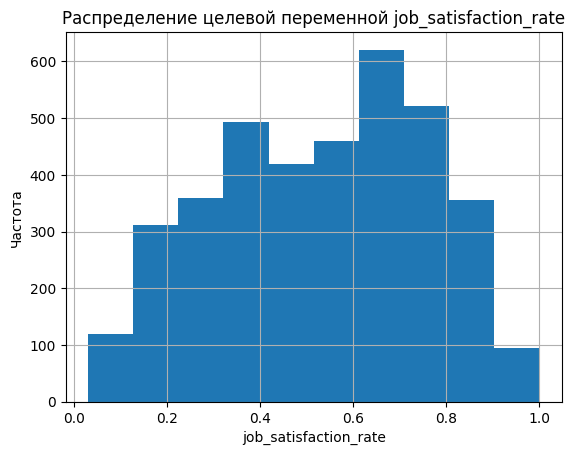

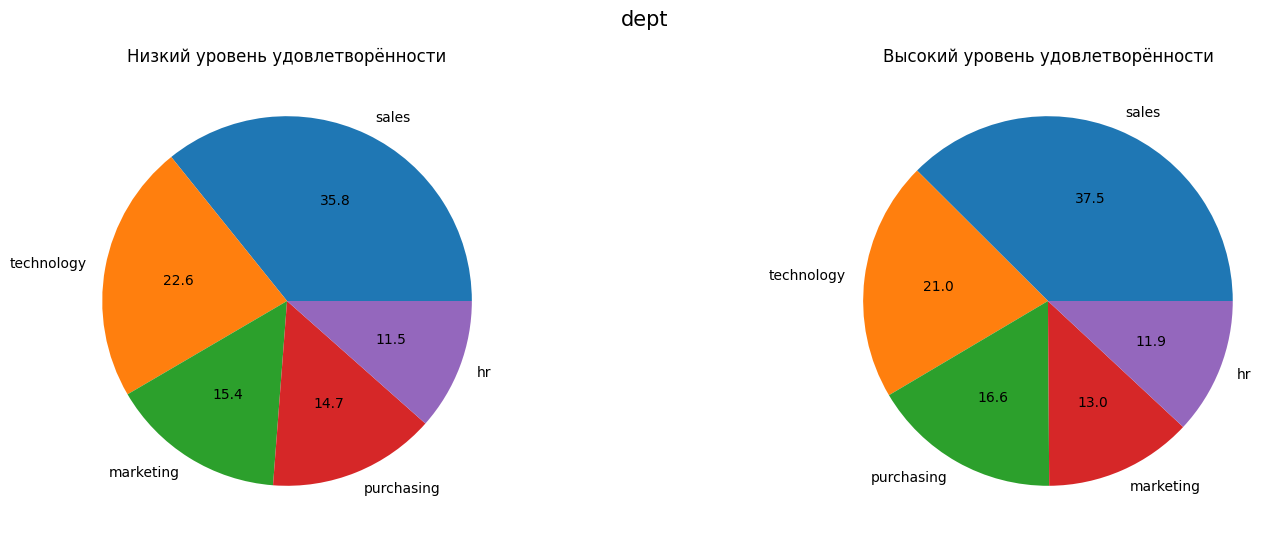

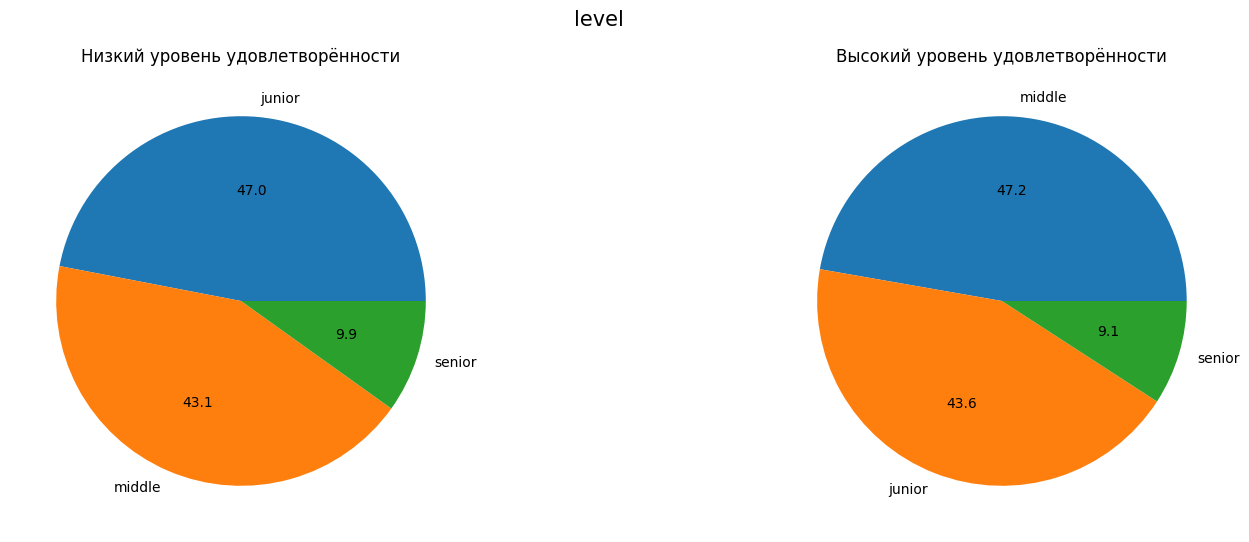

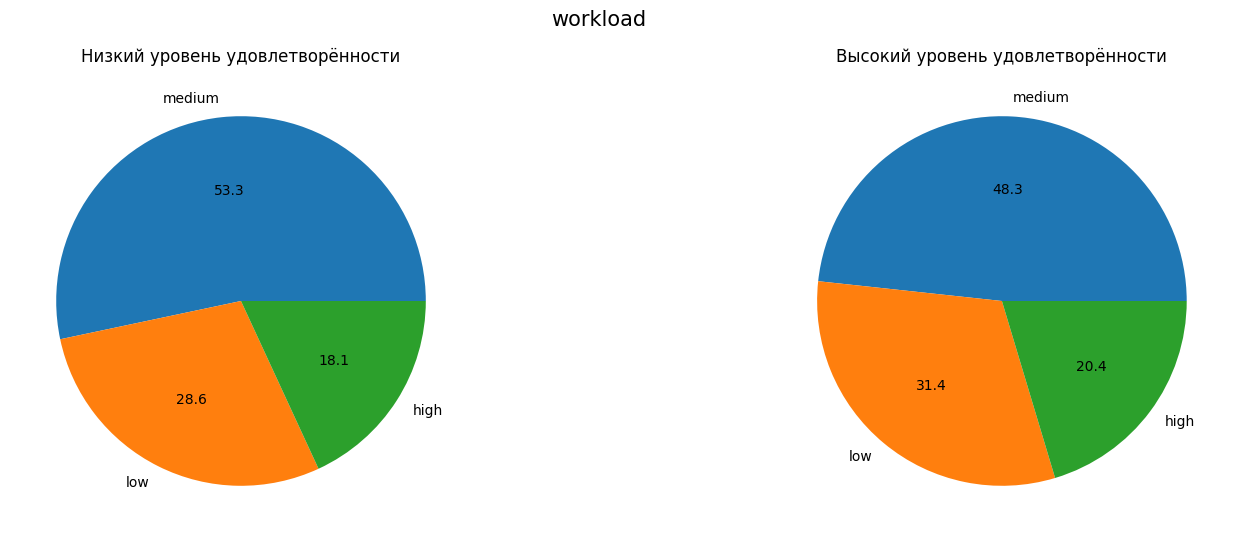

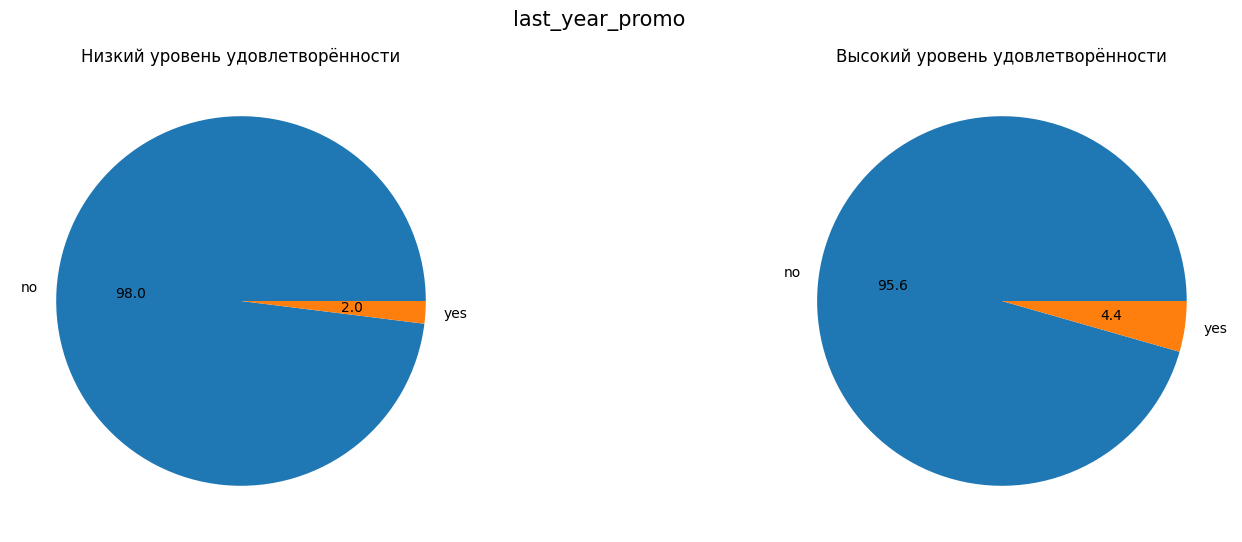

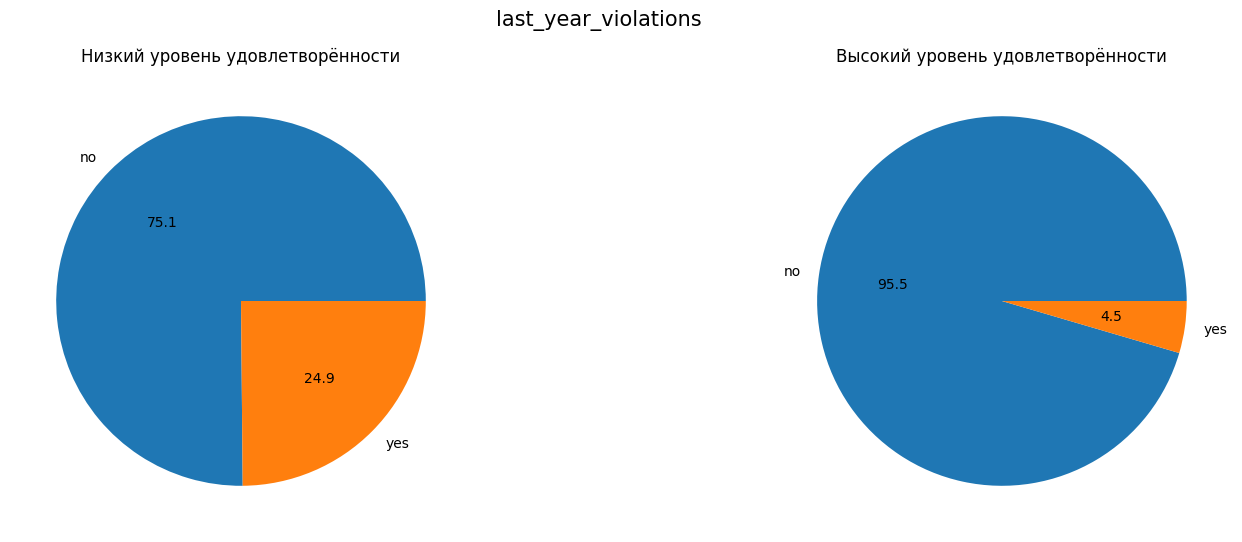

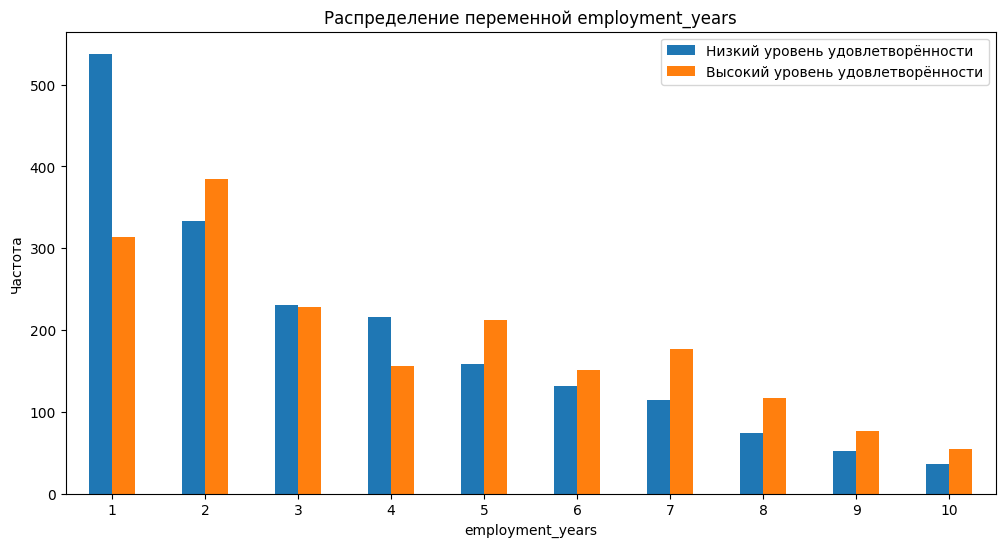

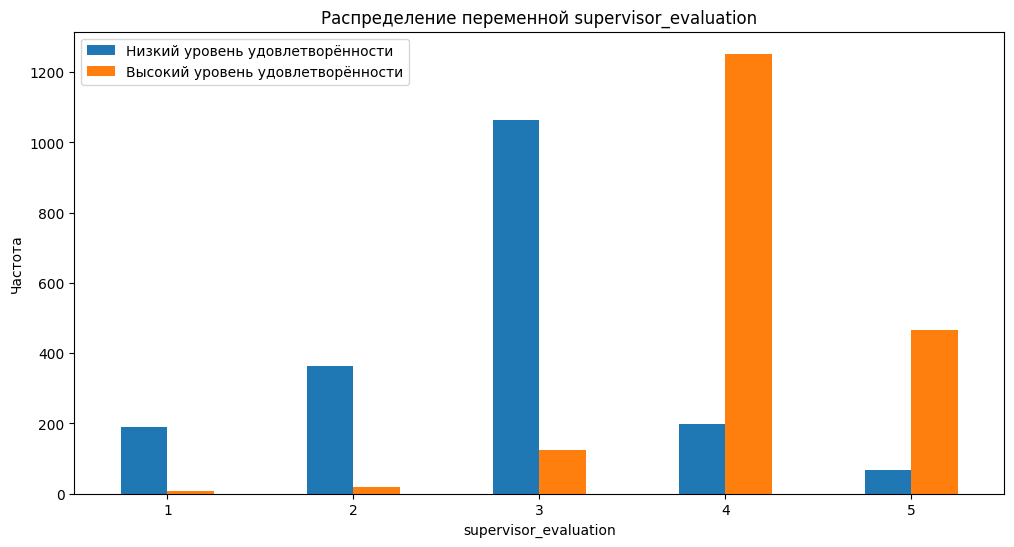

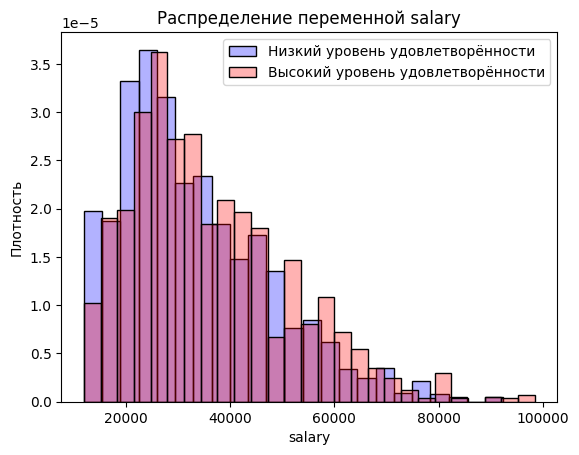

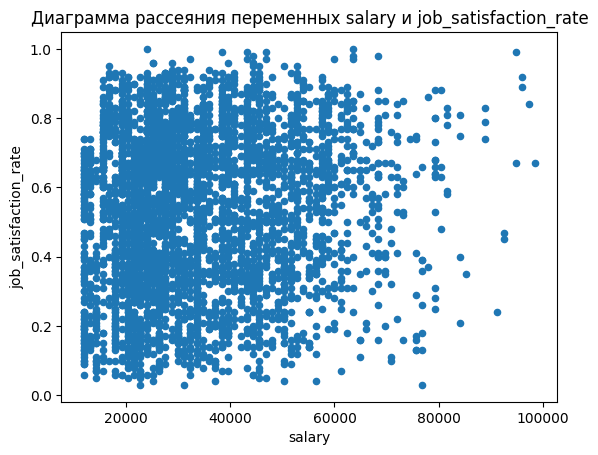

In [7]:
def plot_compare(df, df0, df1, label0, label1, target, excl_obj = tuple(), excl_num = tuple(), target_num=True):
    if target_num:
        df[target].hist(bins=10)
        plt.title(f'Распределение целевой переменной {target}')
        plt.ylabel('Частота')
        plt.xlabel(target)
        plt.show()
        excl_num = [target, *excl_num]
        excl_obj = [*excl_obj]
    else:
        df[target].value_counts().plot(kind='pie', autopct='%.1f')
        plt.title(target)
        plt.ylabel('')
        plt.show()
        excl_obj = [target, *excl_obj]
        excl_num = [*excl_num]
    for name in df0.drop(excl_obj, axis=1).select_dtypes(include=[object]).columns: 
        fig, axes = plt.subplots(1,2,figsize=(18,6))
        plt.title(name)
        df0[name].value_counts().plot(kind='pie', autopct='%.1f', ax=axes[0])
        axes[0].set_title(label0)
        axes[0].set_ylabel('')

        df1[name].value_counts().plot(kind='pie', autopct='%.1f', ax=axes[1])
        axes[1].set_title(label1)
        axes[1].set_ylabel('')
        fig.suptitle(name, fontsize=15)
        plt.show()
    
    for name in df0.drop(excl_num, axis=1).select_dtypes(include=[np.number]).columns:   
        diff = df[name].max()-df[name].min()
        if is_integer_dtype(df0[name]) and diff<=20:
            interm1 = df0[name].value_counts().sort_index()
            interm2 = df1[name].value_counts().sort_index()
            final = interm1.to_frame().join(interm2, how='outer', lsuffix='0').fillna(0)
            final.plot.bar(figsize=(12, 6), rot=0)
            plt.title(f'Распределение переменной {name}')
            plt.xlabel(name)
            plt.ylabel('Частота')
            plt.legend([label0, label1])
            plt.show()
        else: 
            sns.histplot(df0[name], stat='density', common_norm=False, color='blue', alpha=0.3)
            sns.histplot(df1[name], stat='density', common_norm=False, color='red', alpha=0.3)
#             df0[name].hist(bins=10, alpha=0.3)
#             df1[name].hist(bins=10, alpha=0.3)
            plt.title(f'Распределение переменной {name}')
            plt.xlabel(name)
            plt.ylabel('Плотность')
            plt.legend([label0, label1])
            plt.show()
            if target_num:
                df.plot(name, target, kind='scatter')
                plt.title(f'Диаграмма рассеяния переменных {name} и {target}')
                plt.xlabel(name)
                plt.ylabel(target)
                plt.show()
            else:
                pd.DataFrame({label0: [df0[name].mean()], label1: [df1[name].mean()]}).plot.bar(figsize=(8, 4), rot=0)
                plt.title(f'Среднеее значение переменной {name}')
                plt.ylabel(name)
                plt.xticks([])
                plt.show()

point = df[target1].median()
print(point.round(2))
df0 = df[df[target1]<=point]
df1 = df[df[target1]>point]
plot_compare(df, df0, df1, 'Низкий уровень удовлетворённости', 'Высокий уровень удовлетворённости', target1)



In [8]:
test_df = test_df.join(y_df, how='inner')
len(test_df)

2000

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
В `test` добавили целевой признак - молодец, что используешь явное соединение по ключу.

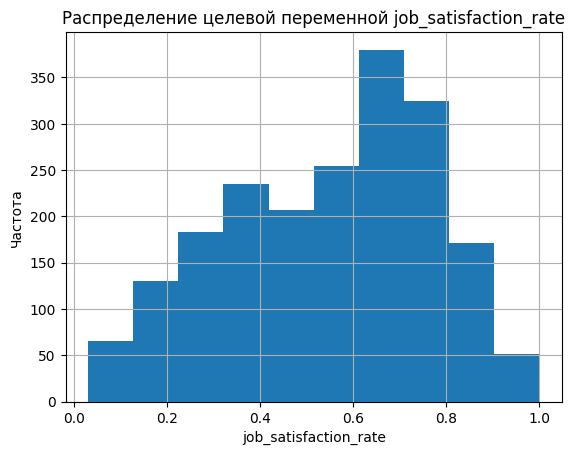

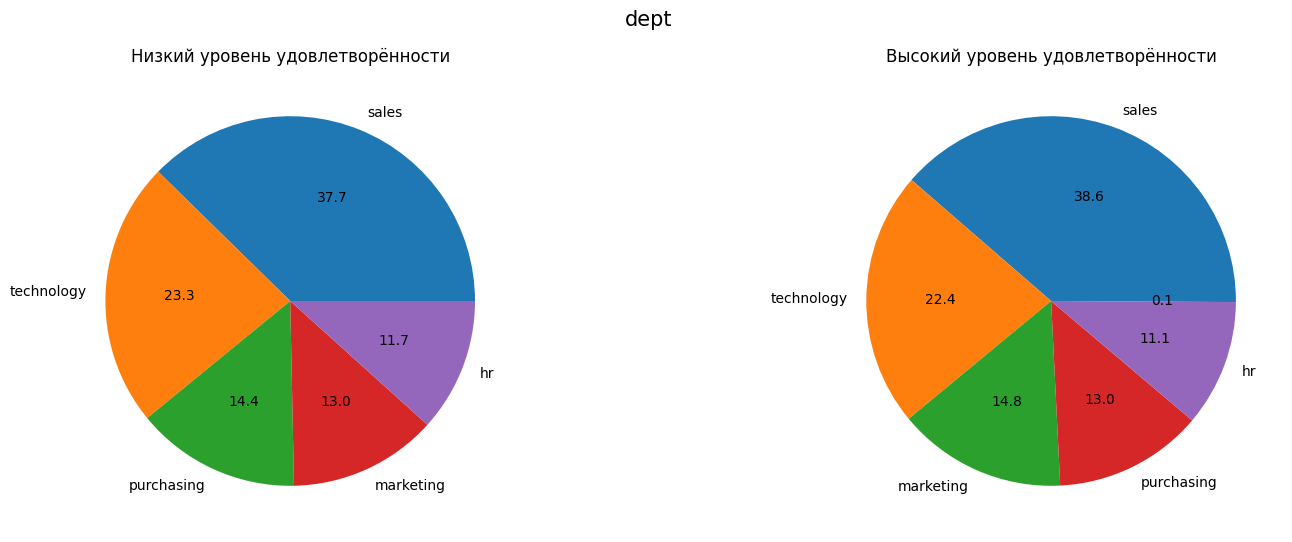

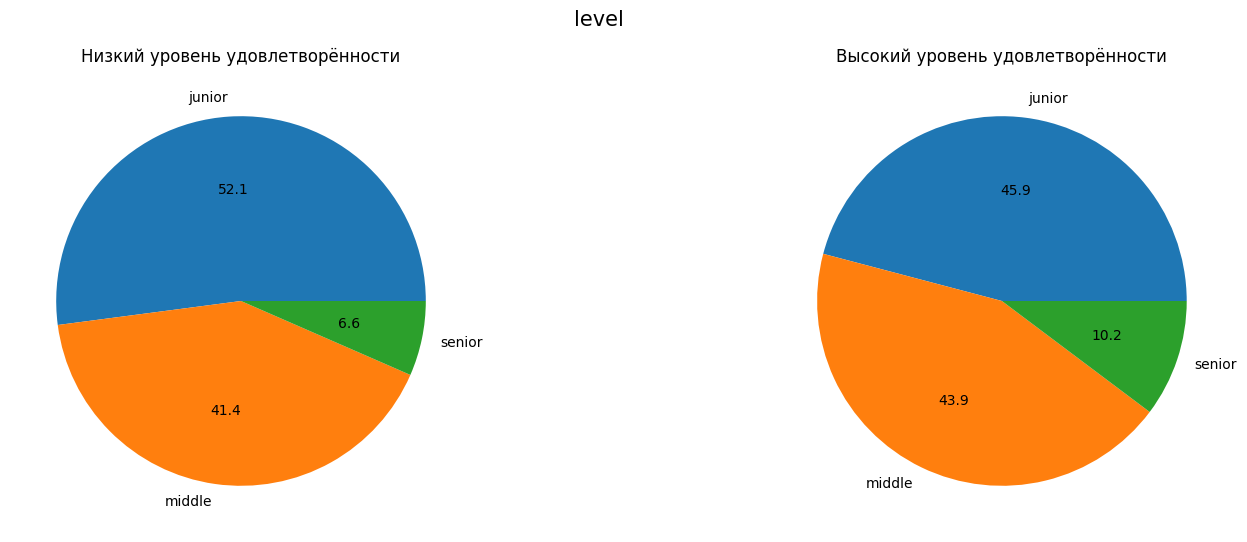

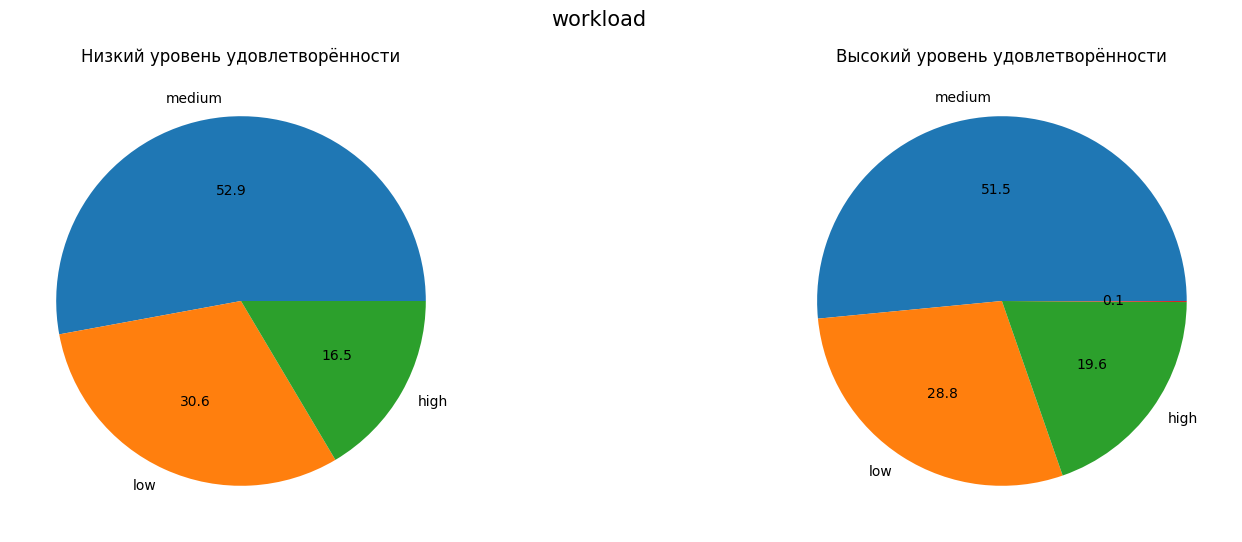

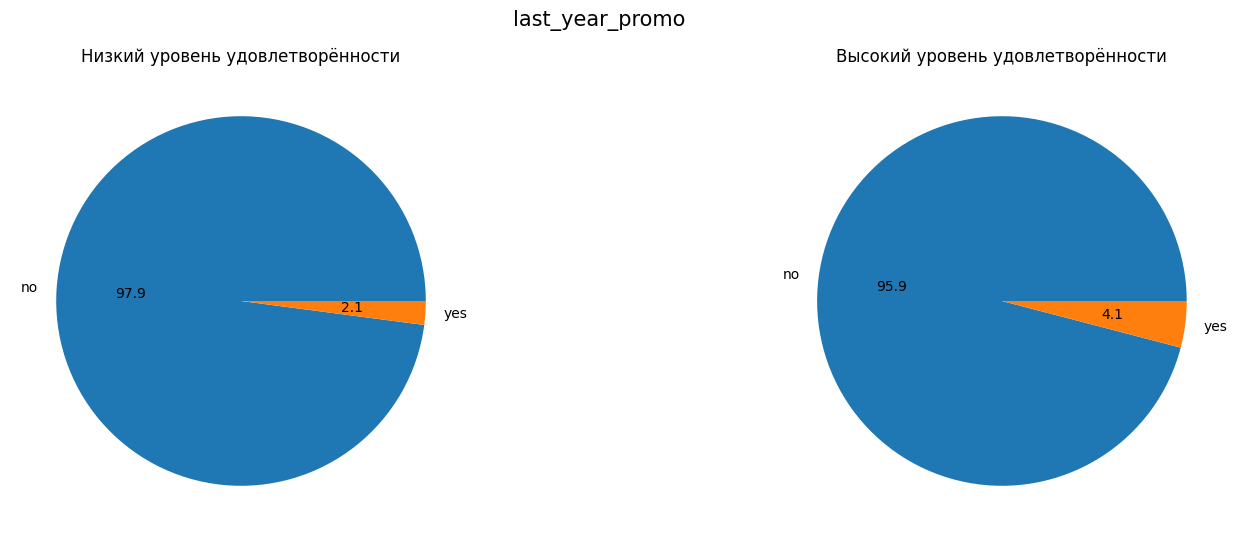

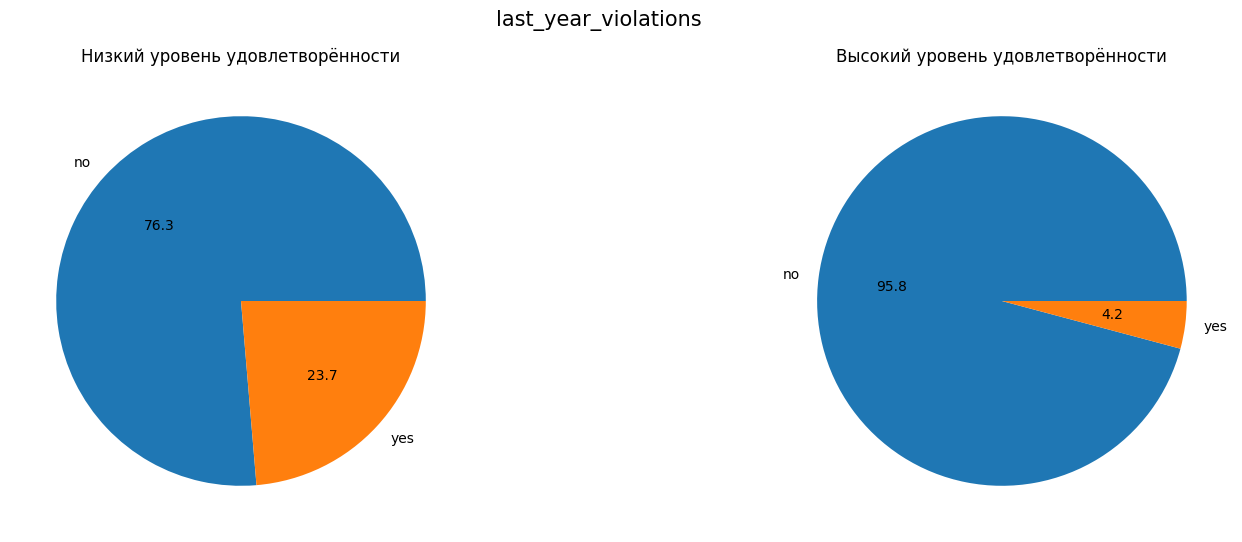

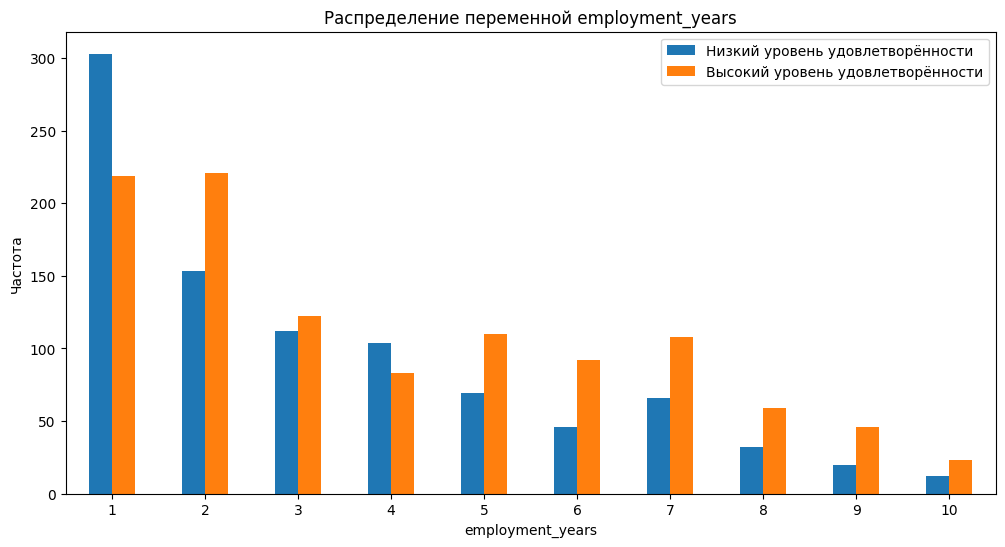

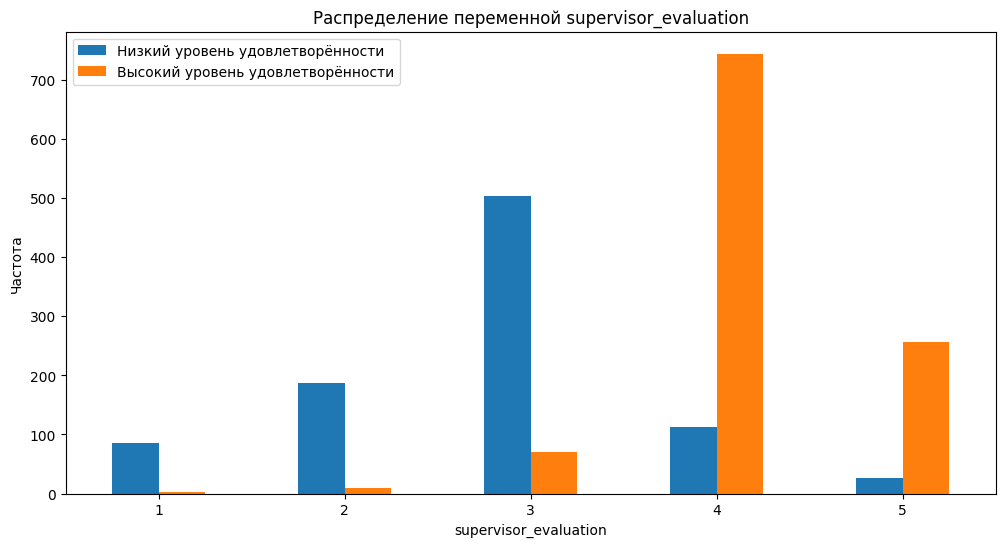

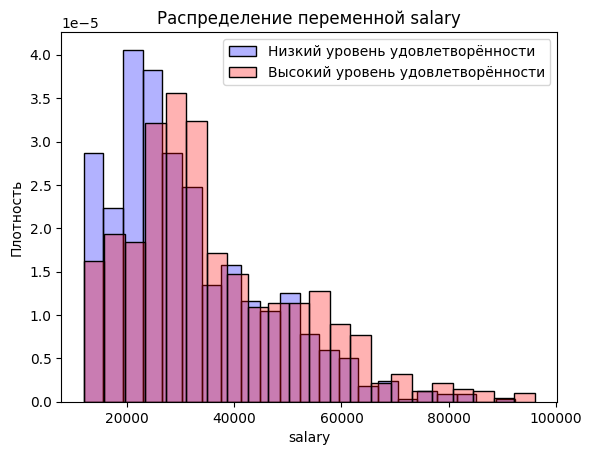

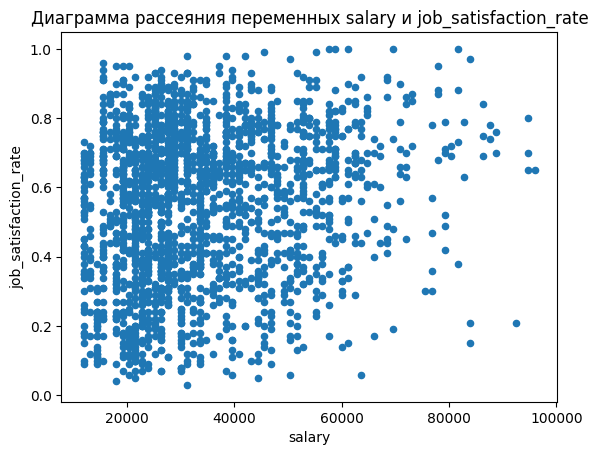

In [9]:
df0 = test_df[test_df['job_satisfaction_rate']<=point]
df1 = test_df[test_df['job_satisfaction_rate']>point]
plot_compare(test_df, df0, df1, 'Низкий уровень удовлетворённости', 'Высокий уровень удовлетворённости', target1)

Посмотрим на коэффициенты корреляции на основе `phik`-матрицы. Заметны ожидаемые кореляции: зарплата коррелирует с уровнем должности (коэффициент 0,72) и нагрузкой (0,79), уровень должности дополнительно связан со стажем (0,68). Целевой признак коррелирует с оценкой руководителя (0,76). Схожие коэффициенты и для тестового датасета.

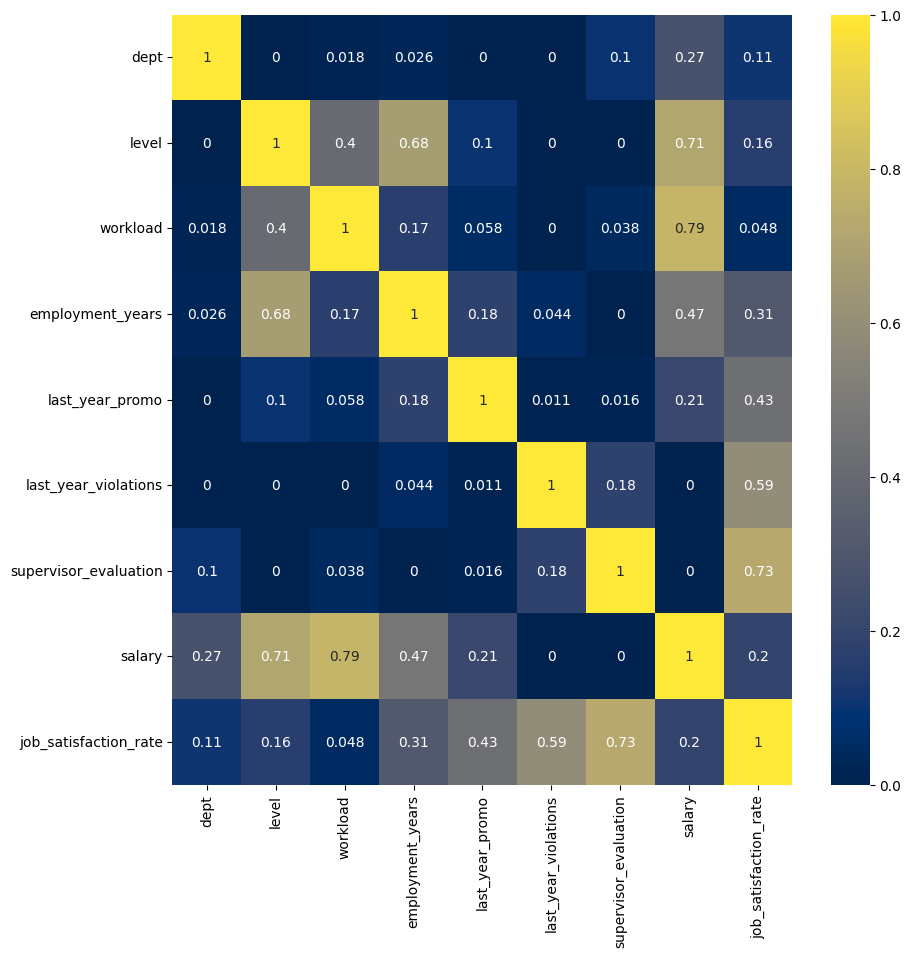

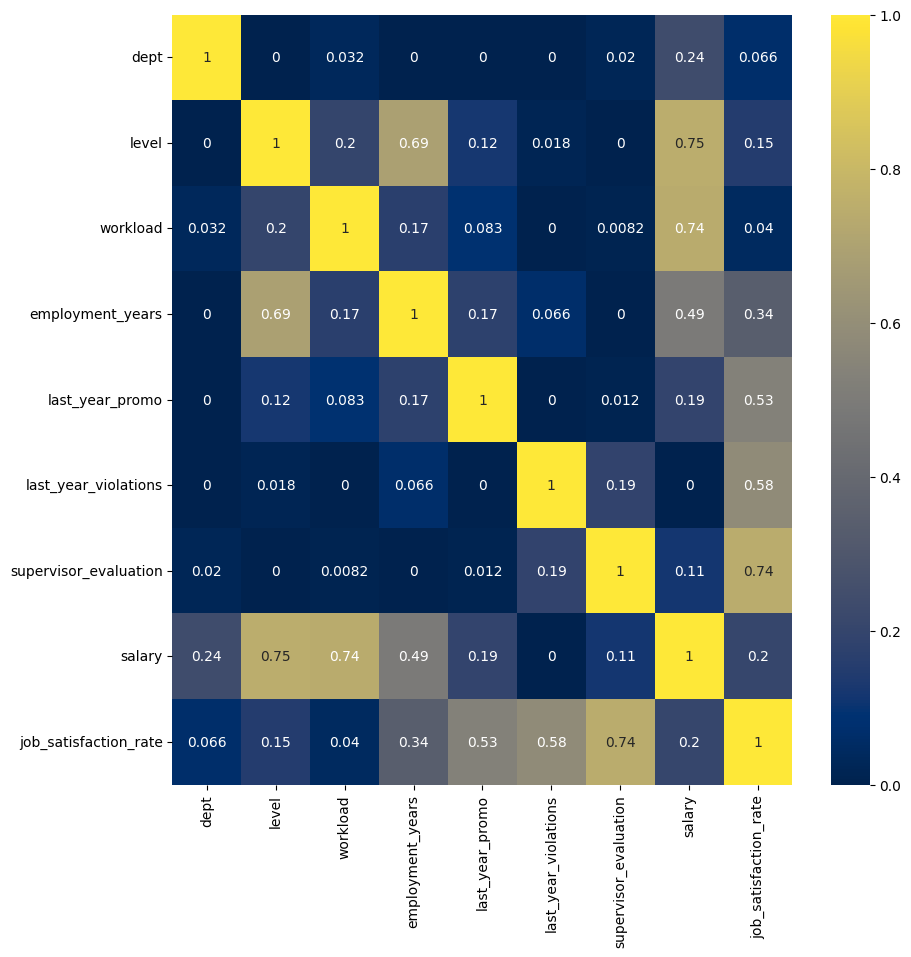

In [10]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.phik_matrix(interval_cols=['salary']), annot=True, cmap='cividis')
plt.show()
plt.figure(figsize=(10, 10))
sns.heatmap(test_df.phik_matrix(interval_cols=['salary']), annot=True, cmap='cividis')
plt.show()

<a name="1.4"></a>

### Пайплайн с подготовкой данных и обучением моделей 

В рамках конвейера произведём подготовку данных. Для категориальных столбцов будет происходить кодирование, а для интервальных - масштабирование и полиномизация. Дополнительно произведём отбор признаков и затем обучим на данных модель. В рамках поиска по решётке перебираются различные гиперпараметры для 4 моделей (метод опорных векторов, дерево, метод ближайших соседей и линейная регрессия с различными видами регуляризации). Среди этих гиперпараметров присутствуют метод масштабирования, степень регуляризации модели, выбор ядра, степень полинома для полиномиального ядра, метод нахождения параметров модели для логистической регрессии, наличие или отсутствие полиномизации признаков и др.

В качестве метрики для нахождения оптимального набора гиперпараметров используется симметричное среднее абсолютное процентное отклонение (SMAPE). Критерий успеха: SMAPE$\le$15 на тестовой выборке.

Как видно, среди изученных наборов гиперпараметров оптимальный результат получается при использовании SVC без полиномизации с параметрами C=3, gamma=0,3, ядро: rbf, метод масштабирования: StandardScaler, количество признаков: 11 (все доступные). Результат на тренировочной выборке при кросс-валидации: 14,791. На тестовой выборке: 13,399. Критерий успеха удовлетворяется.


In [11]:
RANDOM_STATE = 42

In [12]:
def smape_score(y_true, y_pred):
    n = len(y_true)
    return 200 / n * np.sum(np.nan_to_num(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))))


smape = make_scorer(smape_score, greater_is_better=False)

In [13]:
X_train, y_train = df.drop([target1], axis=1), df[target1]
X_test, y_test = test_df.drop([target1], axis=1), test_df[target1]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3755, 8) (3755,)
(2000, 8) (2000,)


In [14]:
ord_columns = pd.Index(['level', 'workload'])
ohe_columns = X_train.drop(ord_columns, axis=1).select_dtypes('object').columns
num_columns = X_train.select_dtypes('number').columns
categories = [['junior', 'middle', 'senior'], ['low', 'medium', 'high']]


In [15]:
num_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

ohe_pipe = Pipeline([
    ('imputer1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('imputer2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')),
])

ord_pipe = Pipeline([
    ('imputer1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('imputer2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=categories, handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('imputer3', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', num_pipe, num_columns),
],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('selector', SelectKBest(k='all')),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [16]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(14, 19),
        'models__min_samples_split': range(10, 18),
        'models__criterion': ['squared_error', 'absolute_error'],
        'models__min_samples_leaf': range(1, 6),
        'selector__k': range(10, 12),
        'preprocessor__num__poly': ['passthrough'],
        'preprocessor__num__scaler': [StandardScaler(), RobustScaler()]
    },

    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(1, int(len(X_train) * 0.005)),
        'models__metric': ['manhattan', 'euclidean'],
        'models__algorithm': ['auto', 'brute'],
        'models__weights': ['uniform', 'distance'],
        'selector__k': range(10, 12),
        'preprocessor__num__poly': ['passthrough'],
        'preprocessor__num__scaler': [StandardScaler(), RobustScaler()]
    },

    {
        'models': [Ridge(random_state=RANDOM_STATE, max_iter=5000)],
        'models__alpha': [0.01, 0.1, 0.3, 0.5, 0.7, 1, 1.5, 2, 3, 5],
        'selector__k': range(12, 18),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    },
    
    {
        'models': [Lasso(random_state=RANDOM_STATE, max_iter=5000)],
        'models__alpha': [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1, 2],
        'selector__k': range(5, 18),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    },

    {
        'models': [SVR()],
        'models__C': [0.1, 0.5, 1, 5],
        'models__gamma': [0.001, 0.005, 0.01, 0.1, 1, 5, 10],
        'models__kernel': ['sigmoid'],
        'selector__k': range(10, 12),
        'preprocessor__num__poly': ['passthrough'],
        'preprocessor__num__scaler': [StandardScaler(), RobustScaler()],
    },

    {
        'models': [SVR()],
        'models__C': [0.05, 0.1, 0.5, 1],
        'models__gamma': [1, 2, 5, 10],
        'models__kernel': ['rbf'],
        'selector__k': range(9, 12),
        'preprocessor__num__poly': ['passthrough'],
        'preprocessor__num__scaler': [StandardScaler(), RobustScaler()],
    },

    {
        'models': [SVR()],
        'models__C': [1, 2, 3, 5, 10],
        'models__gamma': [0.1, 0.2, 0.3, 0.4, 0.5],
        'models__kernel': ['rbf'],
        'selector__k': range(9, 12),
        'preprocessor__num__poly': ['passthrough'],
        'preprocessor__num__scaler': [StandardScaler(), RobustScaler()],
    },
]

In [17]:
use_prev1 = True
filename = 'final_model1.sav'
if use_prev1:
    hyper_search1 = pickle.load(open(filename, 'rb'))
else:
    hyper_search1 = GridSearchCV(
        pipe_final,
        param_grid,
        cv=5,
        scoring=smape,
        verbose=3,
        n_jobs=-1,
        return_train_score=True,
    )

    hyper_search1.fit(X_train, y_train)
    pickle.dump(hyper_search1, open(filename, 'wb'))

print('Лучшая модель и её параметры:\n\n', hyper_search1.best_estimator_)
print(hyper_search1.best_params_)
print(f'Метрика SMAPE лучшей модели при кросс-валидации на тренировочной выборке: {-hyper_search1.best_score_:.3f}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('imputer1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('imputer2',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                  

Сравним результат на тестовой выборки для полученной модели и наивной модели, предсказывающей константное значение (13.399 против 38.262). Проверка на адекватность уверенно пройдена:

In [18]:
y_test_pred = hyper_search1.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {smape_score(y_test, y_test_pred):.3f}')
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
print(f'Метрика SMAPE константной модели на тестовой выборке: {smape_score(y_test, dummy_pred):.3f}')

Метрика SMAPE на тестовой выборке: 13.399
Метрика SMAPE константной модели на тестовой выборке: 38.262


<a name="1.5"></a>

### Интерпретация модели и предварительный вывод 

* Как видно, связь предикторов с целевой переменной нелинейная и неполиномиальная. Так, основанные на линейной связи модели (линейная регрессия с регуляризацией L1 и L2, SVR с линейным и полиномиальным ядром) далеки от нужного результата (SMAPE>20), в том числе при добавлении полиномизации (впрочем, и некатегориальных переменных всего пять, причём четыре из них - оценка качества работы, длительность работы, уровень должности и нагрузка - принимают малое количество значений). В то же время, в целом точки данных неплохо согласуются между собой, и даже метод ближайших соседей способен дать результат около 14 на тестовой выборке (расстояние манхэттена, веса на основе расстояния). Метод SVR и вовсе показывает оценку 13,339. Деревья способны также способны дать довольно хорошее значение (около 13,6).  
* Дополнительно можно отметить, что во всех вариантах лучшие модели содержали в себе все входные признаки, хотя возможность их отбора была предусмотрена в решётке параметров. Значит, все они так или иначе содержат полезную информацию и вносят свой вклад в прогнозирование целевого признака.

Дополнительно проведём тест на важность признаков (permutation importance и SHAP-значения). На графиках заметно, что в обоих тестах выделяются 4 самых важных признака: зарплата, уровень должности, уровень нагрузки, оценка качества работы. Довольно важен оказывается и стаж.

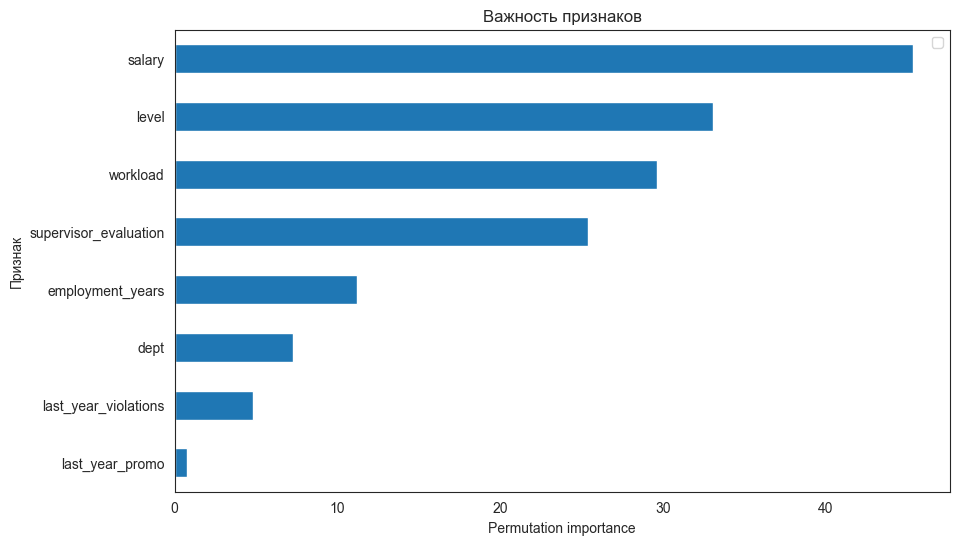

In [19]:
result = permutation_importance(hyper_search1, X_test, y_test, scoring=smape, n_repeats=15, random_state=RANDOM_STATE)
feature_importance = pd.DataFrame({'Feature': X_test.columns, 'Importance': result['importances_mean']}).sort_values(
    'Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title('Важность признаков')
plt.xlabel('Permutation importance')
plt.ylabel('Признак')
plt.legend('')
plt.show()

(2000, 11)
['ohe__dept_marketing' 'ohe__dept_purchasing' 'ohe__dept_sales'
 'ohe__dept_technology' 'ohe__last_year_promo_yes'
 'ohe__last_year_violations_yes' 'ord__level' 'ord__workload'
 'num__employment_years' 'num__supervisor_evaluation' 'num__salary']


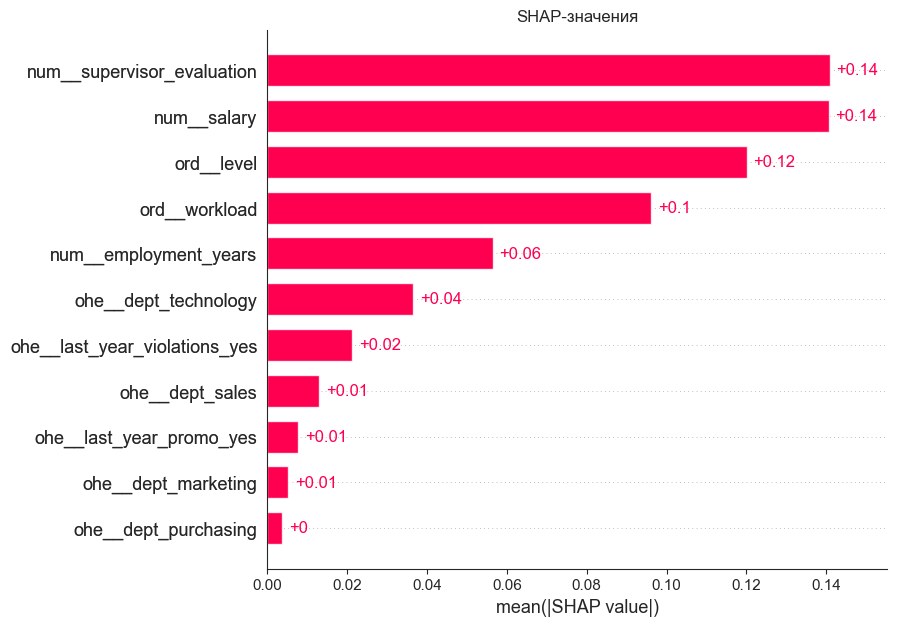

In [20]:
X_test_pre = hyper_search1.best_estimator_['preprocessor'].transform(X_test)
print(X_test_pre.shape)

feature_names = hyper_search1.best_estimator_['preprocessor'].get_feature_names_out()
print(feature_names)
explainer = shap.KernelExplainer(lambda x: hyper_search1.best_estimator_['models'].predict(x),
                                 shap.sample(X_test_pre, 20), feature_names=feature_names)

shap_ready = True
filename1 = 'shap1.pkl'
if shap_ready:
    shap_values = pickle.load(open(filename1, 'rb'))
else:
    shap_values = explainer(X_test_pre)
    pickle.dump(shap_values, open(filename1, 'wb'))

plt.title('SHAP-значения')
shap.plots.bar(shap_values, max_display=20)
plt.show()


Проверим, в каком направлении влияют признаки. Как и ожидалось, сотрудники с высокой зарплатой и оценкой качества работы с большей вероятностью будут удовлетворены компанией, аналогичная тенденция и у сотрудников, которые давно работают в компании. Напротив, работники уровня должности *middle* и выше чаще оказываются недовольными, так же как и сотрудники в отделе технологий и работники с низкой нагрузкой. Вероятно, для сотрудников на высоких должностях и сотрудников отдела технологий не предоставляются достаточно хорошие условия.

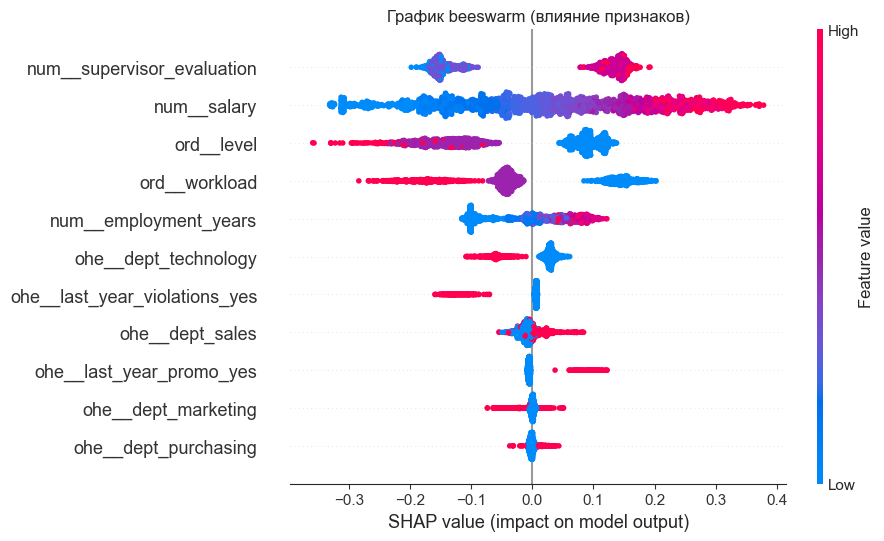

In [21]:
plt.title('График beeswarm (влияние признаков)')
shap.plots.beeswarm(shap_values, max_display=20) 
plt.show()


<a name="2"></a>

## Предсказание увольнения сотрудника из компании

<a name="2.1"></a>

### Загрузка исходных данных 

Загрузим тренировочный датасет и новый целевой признак для тестового датасета. Входные признаки тестового датасета такие же, как и в прошлой задаче (переменная *test_df*):

In [22]:
train = check_and_read('datasets/train_quit.csv', 'id')
train.info()
test_y = check_and_read('datasets/test_target_quit.csv', 'id')
test_y.info()
print(train.head(10))
target2 = 'quit'

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 999029 to 460332
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB
              dept   l

<a name="2.2"></a>

### Предобработка данных 

Убедимся, что в тренировочном наборе данных нет пропусков. Пропуски для тестового набора были удалены в первой части работы.

In [23]:
display(train[(train['level'].isna()) | (train['dept'].isna())])

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,


Исправим опечатки и неявные пропуски, аналогичные обнаруженным в первой части:

In [24]:
for name in train.select_dtypes('object').columns:
    print(name, train[name].unique())
train['level'].replace({'sinior':'senior'}, inplace=True)
print(train['level'].unique())
print(f'Доля дубликатов: {len(train[train.duplicated()])/len(train):.1%}')
train.info()


dept ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level ['middle' 'junior' 'sinior']
workload ['high' 'medium' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
quit ['no' 'yes']
['middle' 'junior' 'senior']
Доля дубликатов: 35.3%
<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


<a name="2.3"></a>

### Исследовательский анализ данных 

При анализе данных в разрезе целевого признака видно, что подавляющая часть уволившихся находятся на позиции *junior*, работают 3 года и менее, имеют несколько более низкие оценки, рабочие нагрузки и зарплаты.

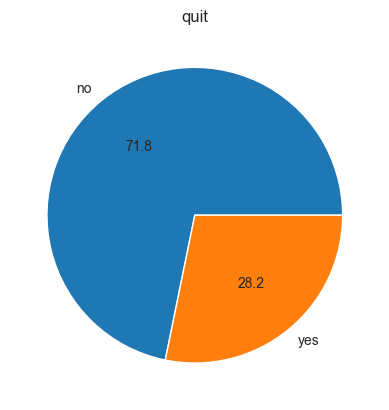

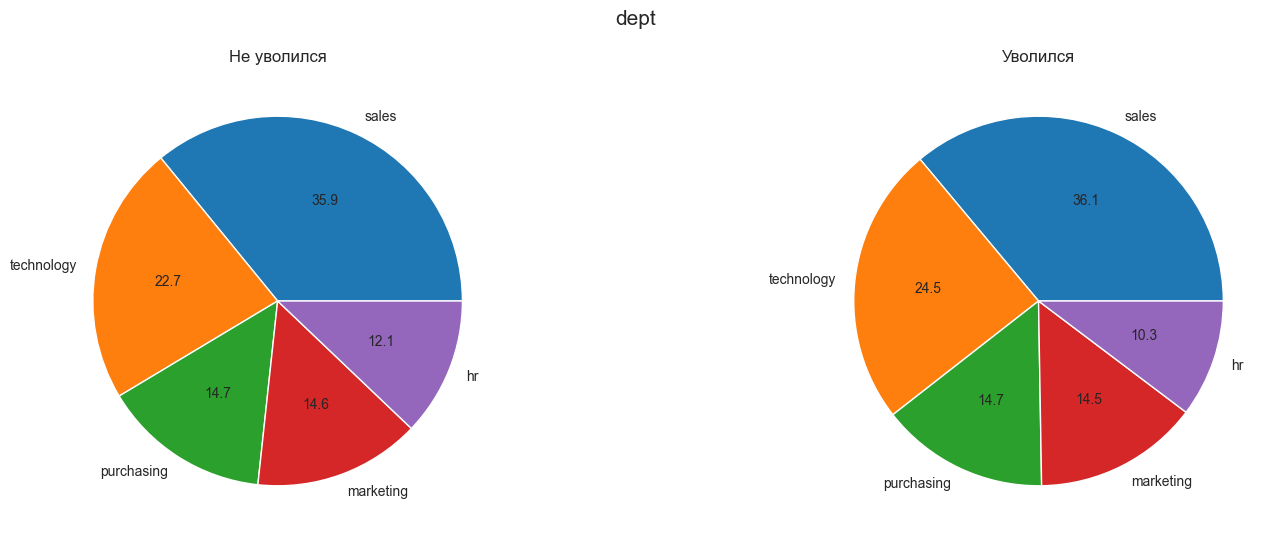

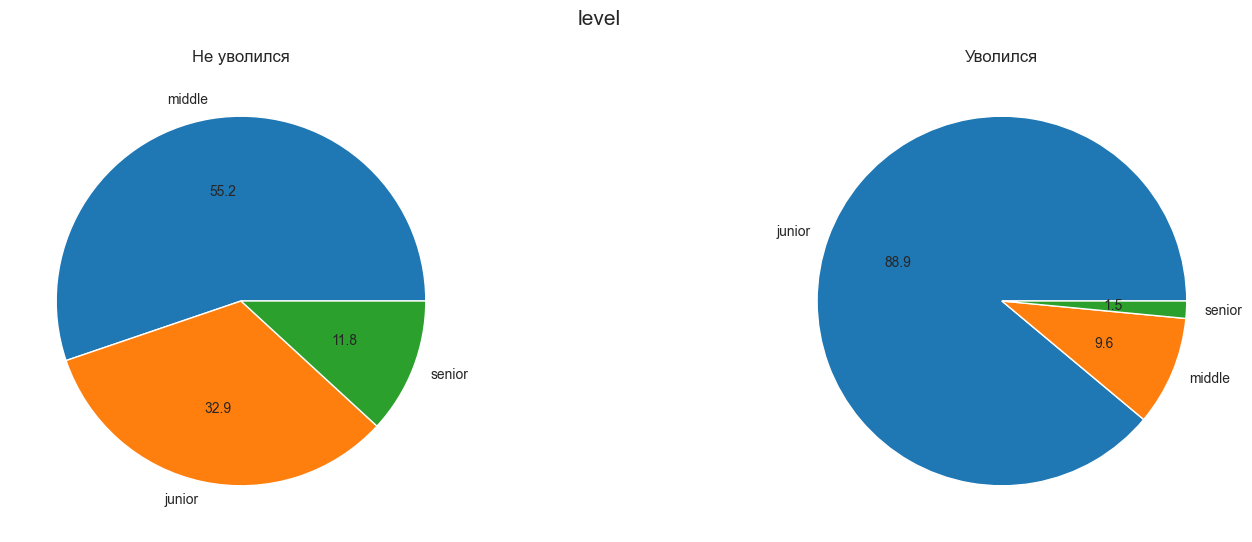

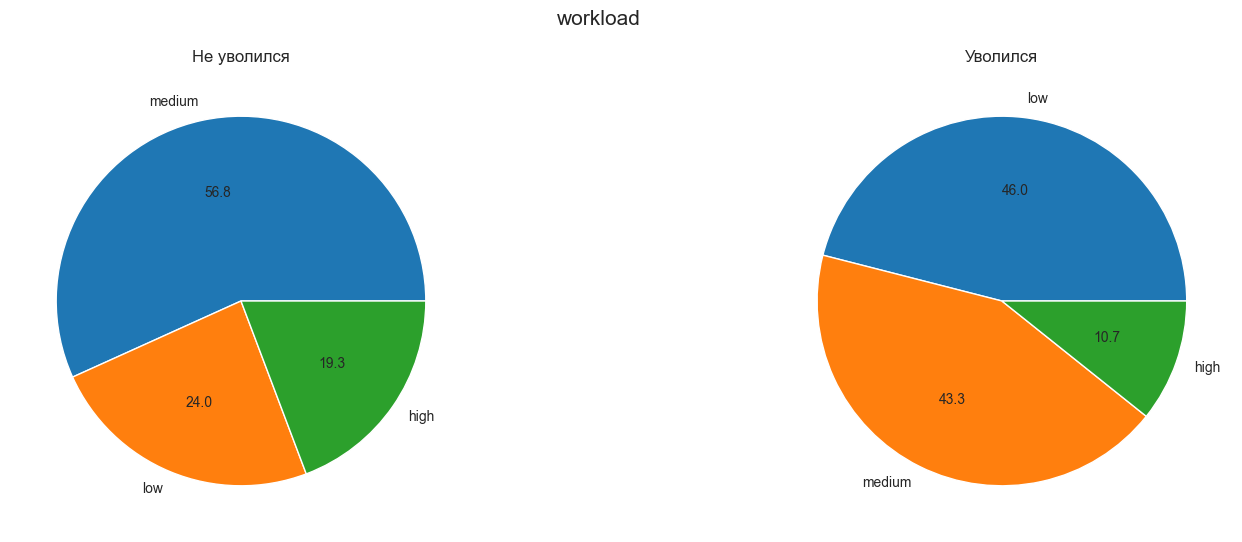

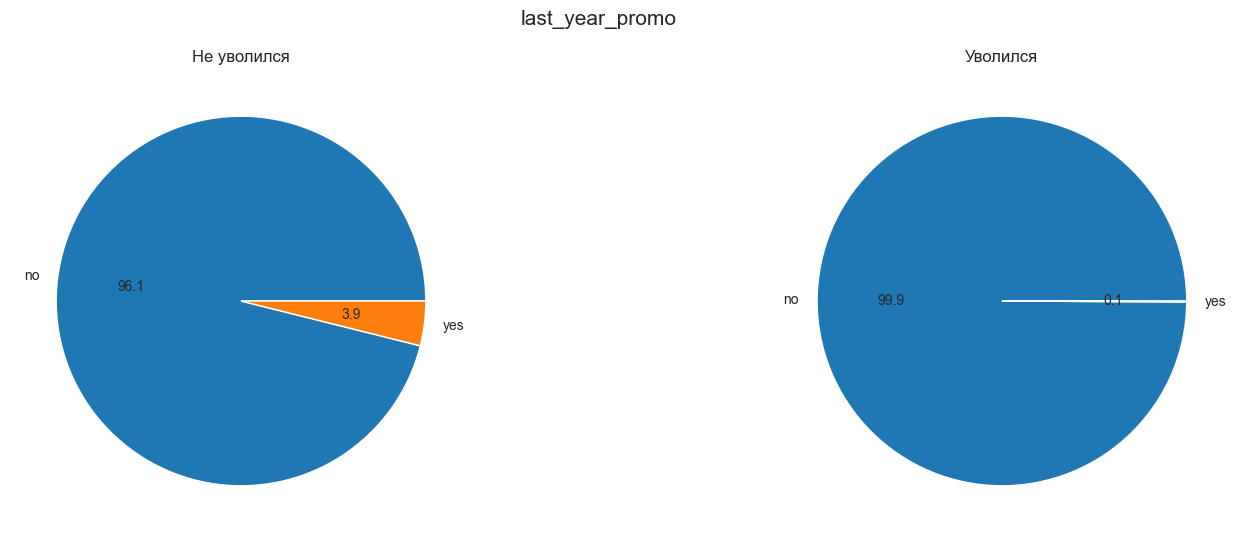

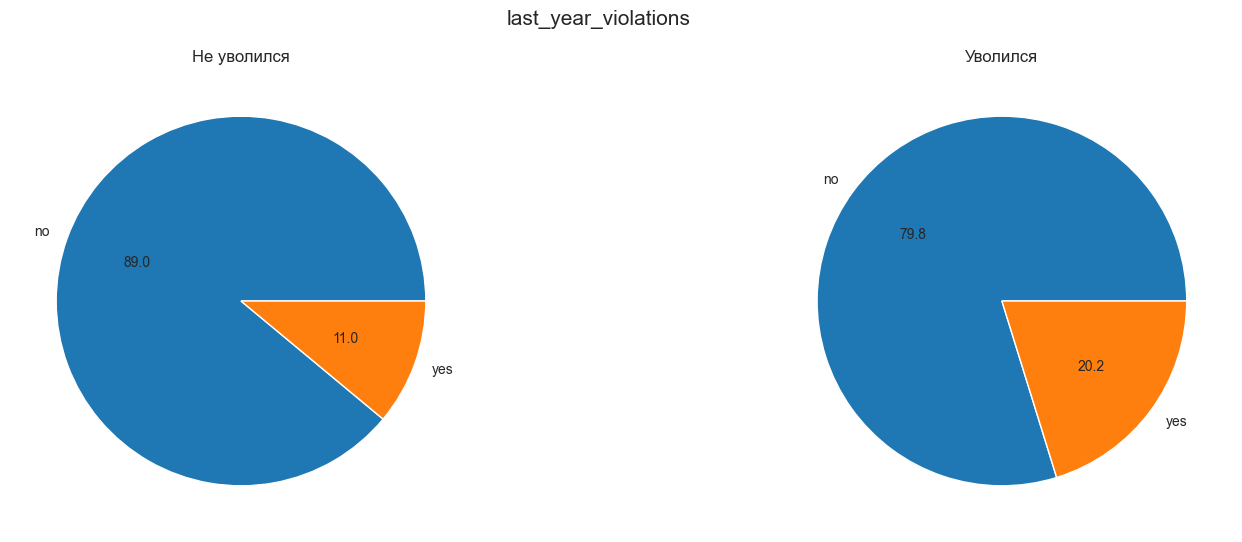

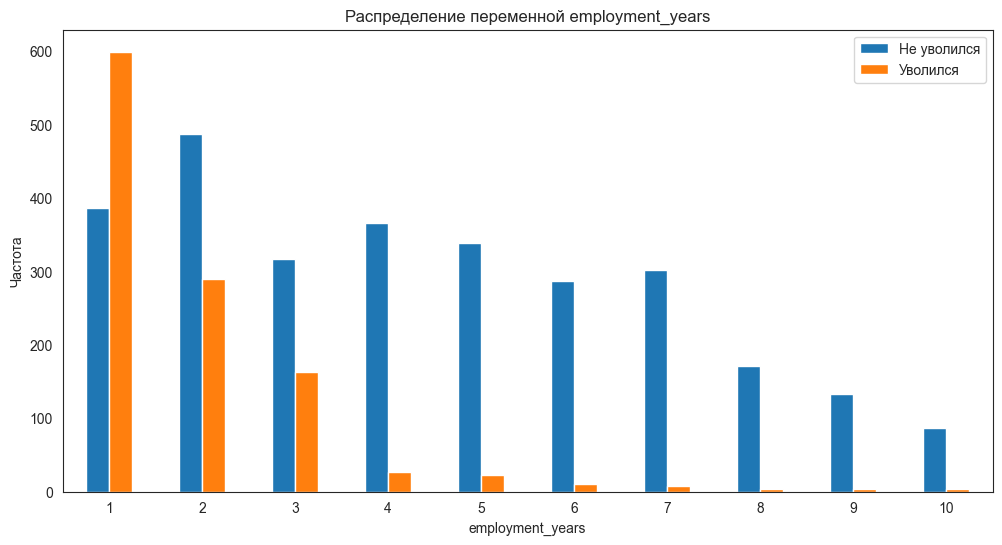

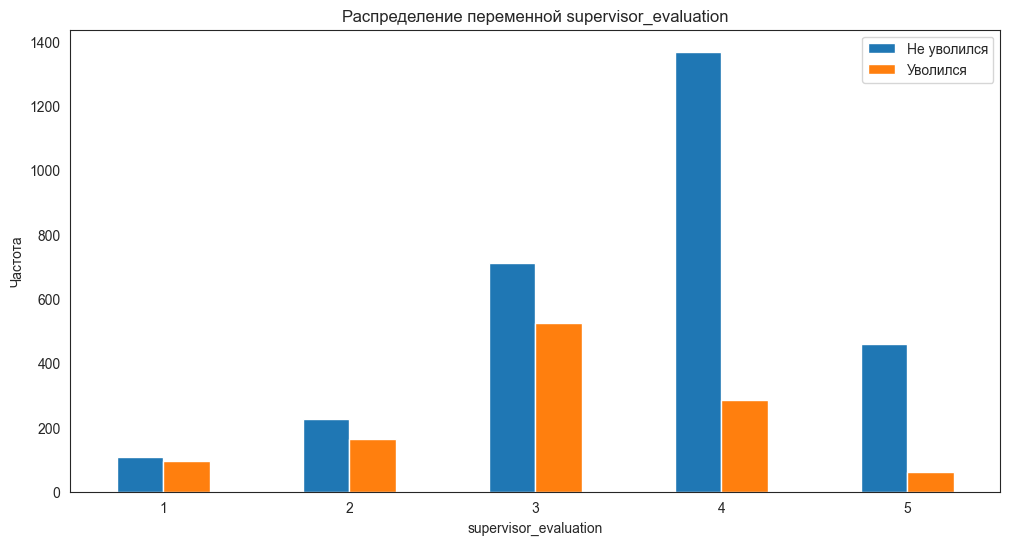

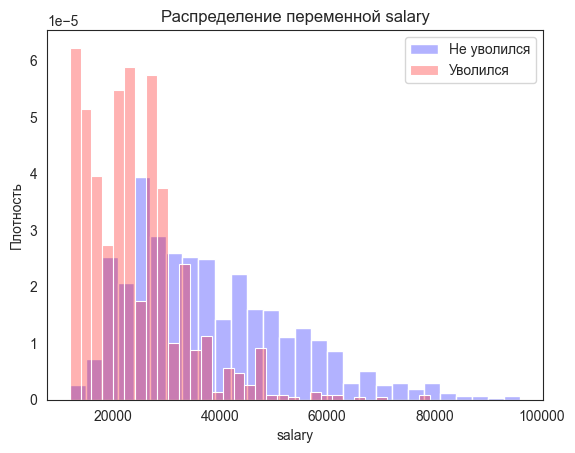

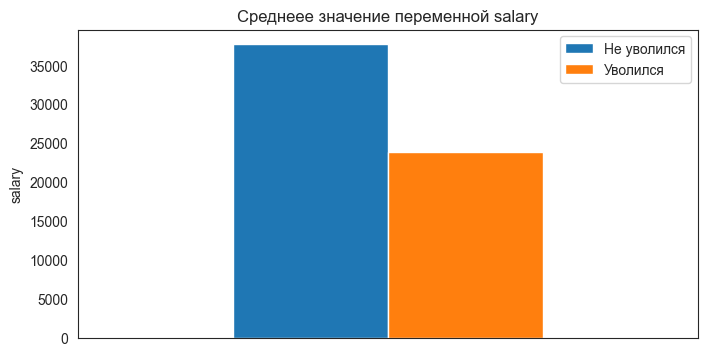

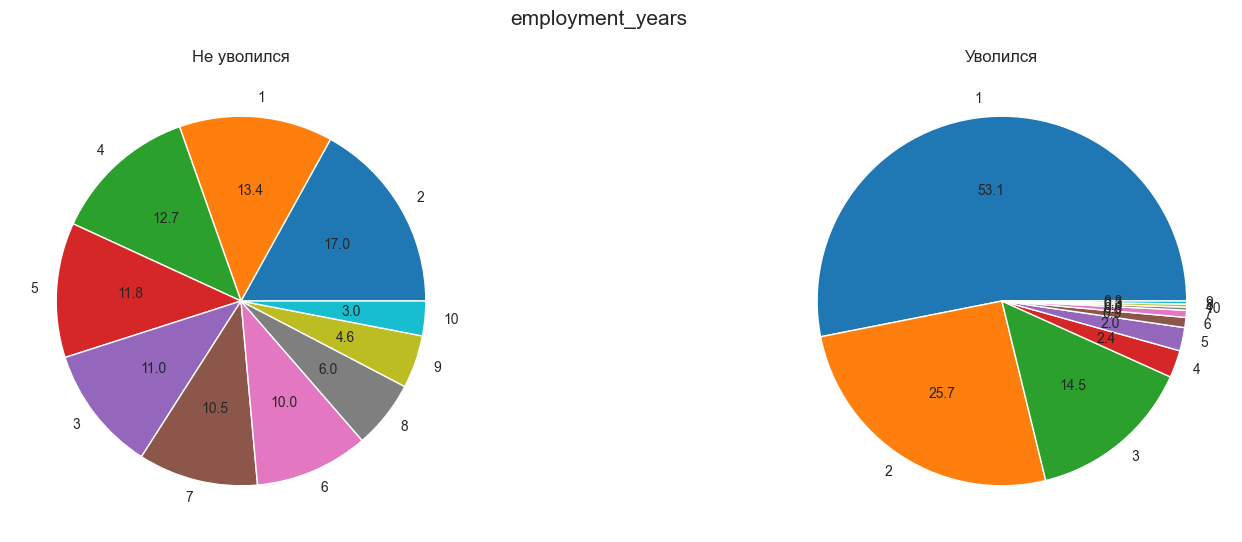

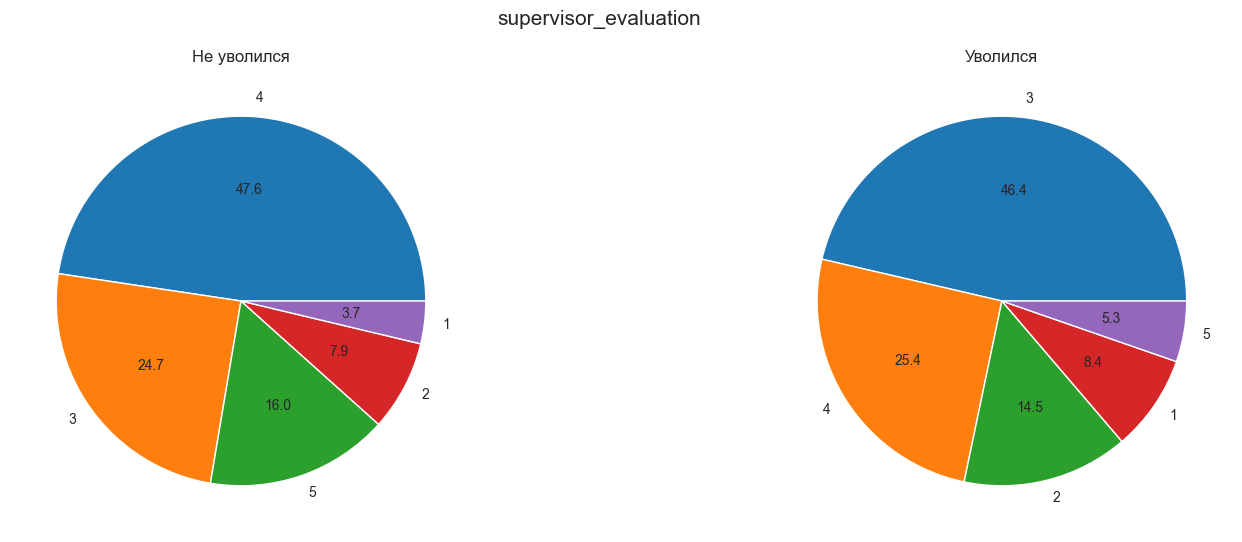

In [25]:
df0 = train[train[target2]=='no']
df1 = train[train[target2]=='yes']
plot_compare(train, df0, df1, 'Не уволился', 'Уволился', target2, target_num=False)

fig, axes = plt.subplots(1,2,figsize=(18,6))
plt.title('employment_years')
df0['employment_years'].value_counts().plot(kind='pie', autopct='%.1f', ax=axes[0])
axes[0].set_title('Не уволился')
axes[0].set_ylabel('')

df1['employment_years'].value_counts().plot(kind='pie', autopct='%.1f', ax=axes[1])
axes[1].set_title('Уволился')
axes[1].set_ylabel('')
fig.suptitle('employment_years', fontsize=15)
plt.show()

fig, axes = plt.subplots(1,2,figsize=(18,6))
plt.title('supervisor_evaluation')
df0['supervisor_evaluation'].value_counts().plot(kind='pie', autopct='%.1f', ax=axes[0])
axes[0].set_title('Не уволился')
axes[0].set_ylabel('')

df1['supervisor_evaluation'].value_counts().plot(kind='pie', autopct='%.1f', ax=axes[1])
axes[1].set_title('Уволился')
axes[1].set_ylabel('')
fig.suptitle('supervisor_evaluation', fontsize=15)
plt.show()

Проверим, влияет ли уровень удовлетворённости сотрудника на то, уволится ли он. При сравнении показателя удовлетворённости уволившихся и оставшихся сотрудников видна большая разница в распределении и среднем значении, а значит ответ на поставленный вопрос положительный.

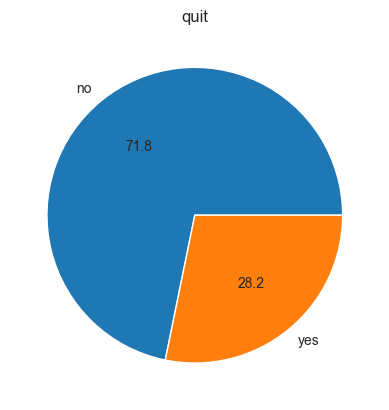

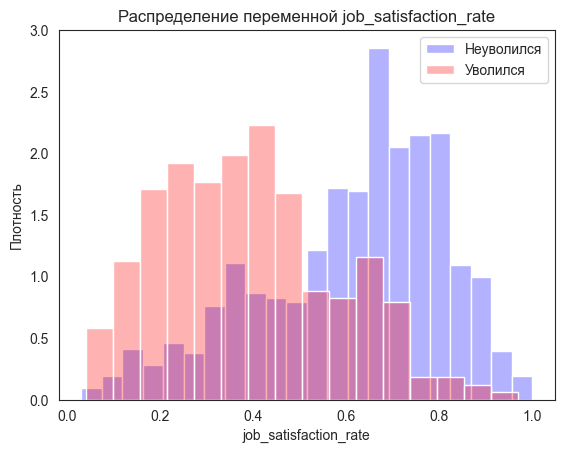

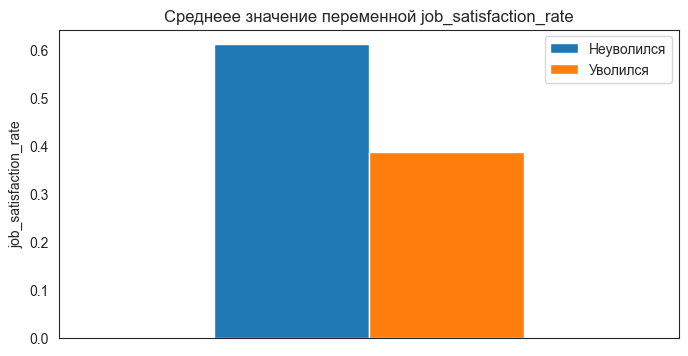

In [26]:
targets_df = y_df.join(test_y)
df0 = targets_df[targets_df['quit']=='no']
df1 = targets_df[targets_df['quit']=='yes']
plot_compare(targets_df, df0, df1, 'Неуволился', 'Уволился', target2, target_num=False)


Посмотрим на матрицу корреляций, в которой в сранении с первой частью добавился новый целевой признак. Как видно, он немного коррелирует со сроком работы (0,66) и зарплатой (0,56):

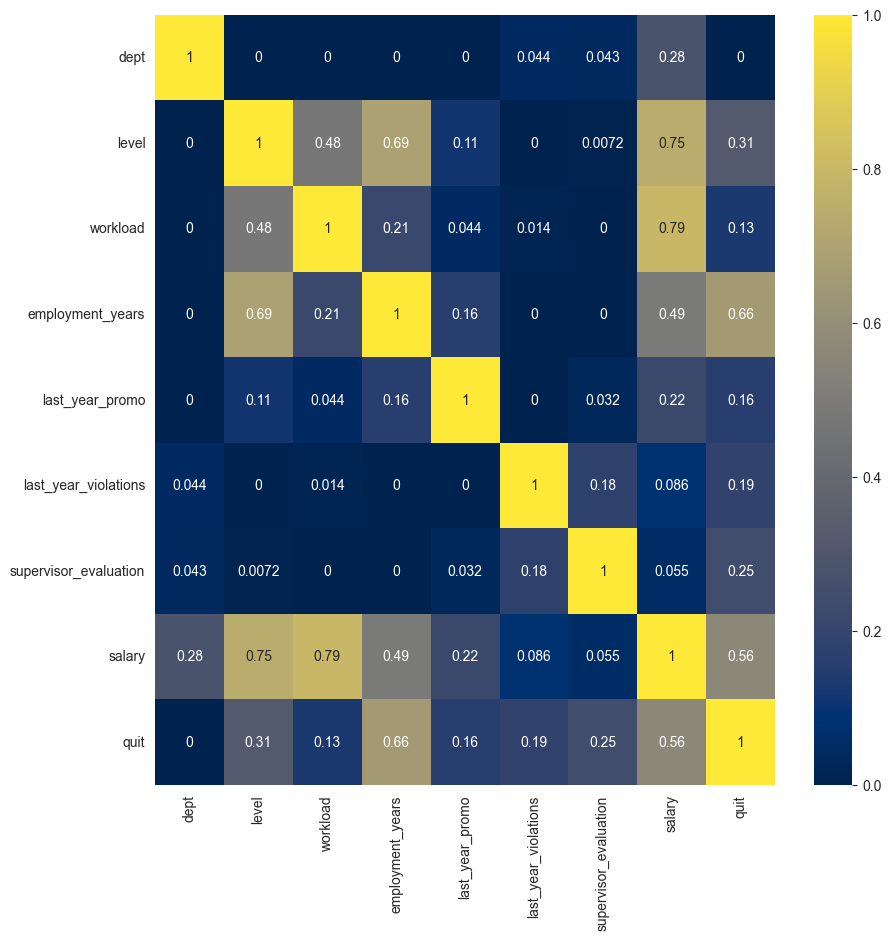

In [27]:
plt.figure(figsize=(10, 10))
sns.heatmap(train.phik_matrix(interval_cols=train.select_dtypes('number').columns), annot=True, cmap='cividis')
plt.show()


<a name="2.4"></a>

### Добавление новых входных признаков 

Для начала в тренировочный и тестовый набор данных добавим признак удовлетворённости сотрудника, предсказанный на основе модели, построенной в первой части работы:

In [28]:
train[target1] = hyper_search1.predict(train.drop([target2], axis=1))
test_df[target1] = hyper_search1.predict(test_df.drop([target1], axis=1))
test_df = test_df.join(test_y, how='inner')
print(train.shape, test_df.shape)


(4000, 10) (2000, 10)


С целью дальнейшего извлечения признаков проанализируем, как взаимодействуют изменение уровня различных интервальных и порядковых переменных с целевым признаком (увольнение сотрудника):

In [29]:
for i in range(1, 6):
    print(f'supervisor_evaluation = {i}', end='; ')
    print(f'Процент не уволившихся: {train[train["supervisor_evaluation"]==i][target2].value_counts(normalize=True).sort_index()[0]:.1%}')
print()
for i in range(1, 11):
    print(f'employment_years= {i}', end='; ')
    print(f'Процент не уволившихся: {train[train["employment_years"]==i][target2].value_counts(normalize=True).sort_index()[0]:.1%}')
print()
for i in np.arange(0.1, 1.1, 0.1):
    print(f'{i-0.1:.0%} < {target1} < {i:.0%}', end='; ')
    print(f'Процент не уволившихся: {train[(train[target1]<=i) & (train[target1]>i-0.1)][target2].value_counts(normalize=True).sort_index()[0]:.1%}')
print()
for i in range(10000, 100000, 10000):
    print(f'{i} < salary < {i+10000}', end='; ')
    print(f'Процент не уволившихся: {train[(train["salary"]<=i+10000) & (train["salary"]>i)][target2].value_counts(normalize=True).sort_index()[0]:.1%}')


supervisor_evaluation = 1; Процент не уволившихся: 53.0%
supervisor_evaluation = 2; Процент не уволившихся: 58.1%
supervisor_evaluation = 3; Процент не уволившихся: 57.6%
supervisor_evaluation = 4; Процент не уволившихся: 82.7%
supervisor_evaluation = 5; Процент не уволившихся: 88.5%

employment_years= 1; Процент не уволившихся: 39.2%
employment_years= 2; Процент не уволившихся: 62.7%
employment_years= 3; Процент не уволившихся: 66.0%
employment_years= 4; Процент не уволившихся: 93.1%
employment_years= 5; Процент не уволившихся: 93.6%
employment_years= 6; Процент не уволившихся: 96.6%
employment_years= 7; Процент не уволившихся: 97.7%
employment_years= 8; Процент не уволившихся: 98.3%
employment_years= 9; Процент не уволившихся: 97.8%
employment_years= 10; Процент не уволившихся: 96.7%

0% < job_satisfaction_rate < 10%; Процент не уволившихся: 30.0%
10% < job_satisfaction_rate < 20%; Процент не уволившихся: 37.2%
20% < job_satisfaction_rate < 30%; Процент не уволившихся: 50.5%
30% < jo

На основе продемонстрированных выше данных для разных переменных можно введением порогов выделить от 2 до 4 основных уровней, в рамках которых доля уволившихся мало отличается (аналог биннинга). Добавим соответствующие "упрощённые" признаки в наборы данных:

In [30]:
train['evaluation_simplified'] = train['supervisor_evaluation'].apply(lambda x: 'high' if x >= 4 else 'low')
test_df['evaluation_simplified'] = test_df['supervisor_evaluation'].apply(lambda x: 'high' if x >= 4 else 'low')
train['stage_simplified'] = train['employment_years'].apply(
    lambda x: 'low' if x == 1 else 'medium' if x < 4 else 'high')
test_df['stage_simplified'] = test_df['employment_years'].apply(
    lambda x: 'low' if x < 1 else 'medium' if x < 4 else 'high')
train['salary_simplified'] = train['salary'].apply(
    lambda x: 'very low' if x < 20000 else 'low' if x < 30000 else 'medium' if x < 50000 else 'high')
test_df['salary_simplified'] = test_df['salary'].apply(
    lambda x: 'very low' if x < 20000 else 'low' if x < 30000 else 'medium' if x < 50000 else 'high')
train['satisfaction_simplified'] = train[target1].apply(
    lambda x: 'very low' if x < 0.1 else 'low' if x < 0.4 else 'medium' if x < 0.6 else 'high')
test_df['satisfaction_simplified'] = test_df[target1].apply(
    lambda x: 'very low' if x < 0.1 else 'low' if x < 0.4 else 'medium' if x < 0.6 else 'high')

<a name="2.5"></a>

### Пайплайн с подготовкой данных и обучением моделей 

Дополнительно закодируем зависимую переменную и проверим, какой класс считается положительным:

In [31]:
le = LabelEncoder()
print(train[target2].unique())
train[target2] = le.fit_transform(train[target2])
test_df[target2] = le.transform(test_df[target2])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

['no' 'yes']
{'no': 0, 'yes': 1}


В рамках конвейера произведём подготовку данных. Для категориальных столбцов будет происходить кодирование, а для интервальных - масштабирование и полиномизация. Дополнительно произведём отбор признаков и затем обучим на данных модель. В рамках поиска по решётке перебираются различные гиперпараметры для 4 моделей (метод опорных векторов, дерево, метод ближайших соседей и логистическая регрессия). Среди этих гиперпараметров присутствуют метод масштабирования, степень регуляризации модели, выбор ядра, степень полинома для полиномиального ядра, метод нахождения параметров модели для логистической регрессии, наличие или отсутствие полиномизации признаков и др.

Метрикой качества выбрана ROC AUC, критерий успеха: ROC AUC $\ge$ 0.91

Как видно, среди изученных наборов гиперпараметров оптимальный результат получается при использовании логистической регрессии с полиномизацией второй степени и параметрами C=20, веса классов: сбалансированные (вес класса обратно пропорционален его частоте), алгоритм оптимизации: saga, регуляризация: l1, количество признаков: 31 (из 31), метод масштабирования: MinMaxScaler. Результат на тренировочной выборке при кросс-валидации: 0,931. На тестовой выборке: 0,921. Критерий успеха удовлетворяется.


In [32]:
RANDOM_STATE = 42

roc_auc = make_scorer(roc_auc_score, needs_proba=True)
X_train, y_train = train.drop([target2], axis=1), train[target2]
X_test, y_test = test_df.drop([target2], axis=1), test_df[target2]

ohe_columns = X_train.drop(ord_columns, axis=1).select_dtypes('object').columns
num_columns = X_train.select_dtypes('number').columns

num_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

ohe_pipe = Pipeline([
    ('imputer1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('imputer2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')),
])

ord_pipe = Pipeline([
    ('imputer1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('imputer2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=categories, handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('imputer3', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', num_pipe, num_columns),
],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('selector', SelectKBest(k='all')),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])


In [33]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(3, 11),
        'models__min_samples_split': range(2, 11),
        'models__min_samples_leaf': range(1, 11),
        'selector__k': range(17, 22),
        'preprocessor__num__poly': ['passthrough'],
        'preprocessor__num__scaler': [StandardScaler(), RobustScaler()]
    },

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, int(len(X_train) * 0.01)),
        'models__metric': ['manhattan', 'euclidean'],
        'models__weights': ['uniform', 'distance'],
        'selector__k': range(17, 22),
        'preprocessor__num__poly': ['passthrough'],
        'preprocessor__num__scaler': [StandardScaler(), RobustScaler()]
    },

    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, max_iter=10000)],
        'models__C': [10, 20, 25, 30],
        'models__class_weight': ['balanced'],
        'models__penalty': ['l1', 'l2'],
        'models__solver': ['saga', 'liblinear', ],
        'selector__k': range(24, 32),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [40, 50, 60,],
        'models__gamma': [0.01, 0.02, 0.03],
        'models__kernel': ['rbf'],
        'selector__k': range(14, 20),
        'preprocessor__num__poly': ['passthrough'],
        'preprocessor__num__scaler': [StandardScaler(), RobustScaler()],
    },

    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='linear', probability=True)],
        'models__C': [50, 60, 70],
        'models__gamma': ['scale', 'auto'],
        'selector__k': range(26, 32),
        'preprocessor__num__scaler': [MinMaxScaler()]
    },
]

hyper_search2 = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=roc_auc,
    verbose=3,
    n_jobs=-1,
    return_train_score=True,
)

use_prev2 = True
filename = 'final_model2.sav'
if use_prev2:
    hyper_search2 = pickle.load(open(filename, 'rb'))
else:
    hyper_search2.fit(X_train, y_train)
    pickle.dump(hyper_search2, open(filename, 'wb'))

print('Лучшая модель и её параметры:\n\n', hyper_search2.best_estimator_)
print(hyper_search2.best_params_)
print(f'Метрика roc auc лучшей модели на тренировочной выборке: {hyper_search2.best_score_:.3f}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('imputer1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('imputer2',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                  

Сравним результат на тестовой выборки для полученной модели и наивной модели, предсказывающей константное значение (0.921 против 0.5). Проверка на адекватность уверенно пройдена:

In [34]:
y_test_pred = hyper_search2.predict_proba(X_test)[:, 1]
print(f'Метрика roc auc на тестовой выборке: {roc_auc_score(y_test, y_test_pred):.3f}')
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict_proba(X_test)[:, 1]
print(f'Метрика  roc auc константной модели на тестовой выборке: {roc_auc_score(y_test, dummy_pred):.3f}')

Метрика roc auc на тестовой выборке: 0.921
Метрика  roc auc константной модели на тестовой выборке: 0.500


Визуализируем ROC-кривую для полученной модели:

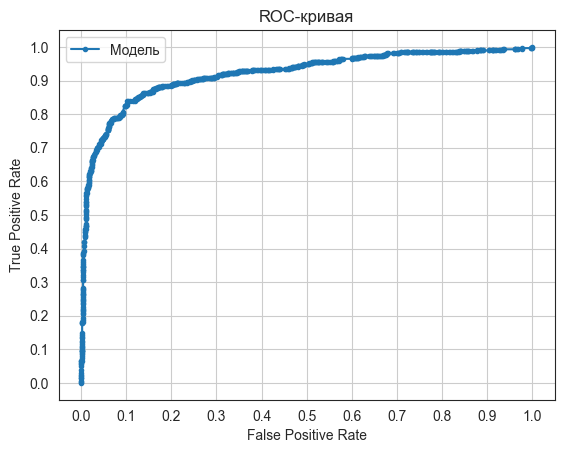

In [35]:
y_pred = hyper_search2.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, marker='.', label='Модель')
plt.title('ROC-кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.grid()
plt.show()


<a name="2.6"></a>

### Интерпретация модели и предварительный вывод 

* Как видно из промежуточных результатов модели, связь предикторов и целевой переменной имеет близкий линейному и полиномиальному характер. Так, модели, основанные на линейных связях (логистическая регрессия и метод опорных векторов с линейный ядром) сумели показать результат ROC AUC > 0,9.
* Дополнительно можно отметить, что лушая модель содержала в себе все доступные признаки (31 с учётом полиномизации). Вероятно, отчасти это связано с l1 регуляризацией, в рамках которой малополезные признаки часто почти обнуляются. И всё же созданные признаки оказались информативны для модели. Ниже посмотрим на важность признаков, чтобы лучше понять ситуацию. Используем для этого permutation importance и коэффициенты модели.

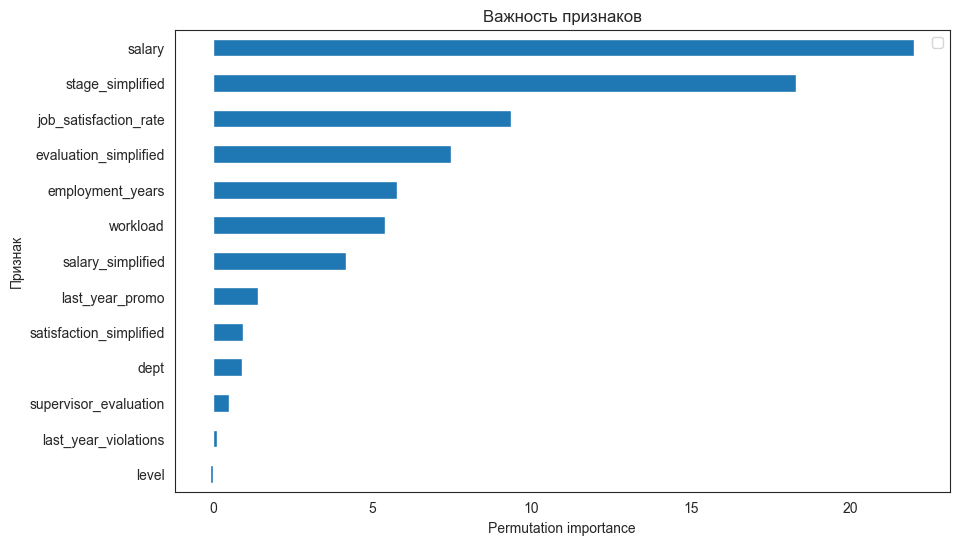

In [36]:
result = permutation_importance(hyper_search2, X_test, y_test, scoring=smape, n_repeats=15, random_state=RANDOM_STATE)
feature_importance = pd.DataFrame({'Feature': X_test.columns, 'Importance': result['importances_mean']}).sort_values(
    'Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title('Важность признаков')
plt.xlabel('Permutation importance')
plt.ylabel('Признак')
plt.legend('')
plt.show()


In [37]:
selected = hyper_search2.best_estimator_['selector'].get_support(indices=True)
feature_names = [x[5:] for x in hyper_search2.best_estimator_['preprocessor'].get_feature_names_out()[selected]]
print(feature_names)

coef_df = pd.DataFrame({'Переменная': feature_names, 'Коэффициент': hyper_search2.best_estimator_['models'].coef_[0].round(2)}).sort_values(by='Коэффициент', ascending=False).reset_index(drop=True)
coef_df


['dept_marketing', 'dept_purchasing', 'dept_sales', 'dept_technology', 'last_year_promo_yes', 'last_year_violations_yes', 'evaluation_simplified_low', 'stage_simplified_low', 'stage_simplified_medium', 'salary_simplified_low', 'salary_simplified_medium', 'salary_simplified_very low', 'satisfaction_simplified_low', 'satisfaction_simplified_medium', 'satisfaction_simplified_very low', 'level', 'workload', 'employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate', 'employment_years^2', 'employment_years supervisor_evaluation', 'employment_years salary', 'employment_years job_satisfaction_rate', 'supervisor_evaluation^2', 'supervisor_evaluation salary', 'supervisor_evaluation job_satisfaction_rate', 'salary^2', 'salary job_satisfaction_rate', 'job_satisfaction_rate^2']


,Переменная,Коэффициент
0,salary job_satisfaction_rate,13.97
1,employment_years job_satisfaction_rate,11.32
2,job_satisfaction_rate,10.63
3,salary^2,7.04
4,employment_years salary,3.95
5,stage_simplified_low,3.39
6,stage_simplified_medium,2.32
7,salary_simplified_very low,2.27
8,satisfaction_simplified_very low,2.07
9,supervisor_evaluation salary,1.76


Заметно, что выделение новых признаков с помощью биннинга и полиномизации оправдало себя, так как эти признаки входят в число важнейших. Наибольшую значимость показывают зарплата и срок работы. В целом, видно, что легче всего удерживать сотрудников с высокой зарплатой и степенью удовлетворённости, а также долгим сроком работы и получивших повышение за последний год.  Напротив, сотрудники  с невысокими (средним и ниже) стажем и зарплатой, низким и очень низким уровнем удовлетворённости, высокими нагрузками и нарушениями за последний год находятся в зоне повышенного риска. Также стоит отметить отдел технологий, в нём вероятность увольнений выше.

<a name="3"></a>

## Общий вывод 

В ходе работы был проведён анализ данных с характеристиками сотрудников компании «Работа с заботой» с целью предсказать их уровень удовлетворённости и выявить тех, кто собирается уволиться из компании. 
Работа состояла из следующих этапов:
1.  Предсказание уровня удовлетворённости сотрудника.  
    1) Загрузка данных. Всего 3 датасета: тренировочный (4000 сотрудников), тестовый со входными данными и тестовый с целевым признаком (по 2000).  
    2) Предобработка данных. Были обнаружены ошибки, явные и неявные пропуски, дубликаты, их общая доля: 6,4% на тренировочном и 28,1% на тестовом наборе данных.  
    3) Исследовательский анализ данных. Было выявлено, что сотрудники с низкой оценкой качества работы от руководителя, нарушениями трудового договора за последний годи и проработавшие год или меньше чаще неудовлетворены. Работники с высокой зарплатой и низким уровнем нагрузки скорее довольны своим положением.  
    4) Пайплайн с подготовкой данных и обучением моделей. Были испробованы 4 вида моделей: дерево, опорные вектора, линейная регрессия и метод ближайших соседей. Оптимальный результат получен при использовании SVC без полиномизации с параметрами C=3, gamma=0,3, ядро: rbf, метод масштабирования: StandardScaler, количество признаков: 11 (все доступные). Результат на тестовой выборке: SMAPE = 13,399. SMAPE < 15, следовательно критерий успеха удовлетворяется.  
    5) Интерпретация модели и предварительный вывод. Связь предикторов с целевой переменной нелинейная и неполиномиальная. Все входные признаки оказались важны для модели. 5 самых важных признаков: зарплата, уровень должности, уровень нагрузки, оценка качества работы и стаж. Работники уровня должности *middle* и выше, сотрудники в отделе технологий и работники с низкой нагрузкой чаще оказываются недовольными. Вероятно, для этих категорий не предоставляются достаточно хорошие условия.
2. Предсказание увольнения сотрудника.  
    1) Загрузка данных. Вновь 3 датасета: новый тренировочный (4000 сотрудников), прежний тестовый со входными данными и новый тестовый с целевым признаком (по 2000).  
    2) Предобработка данных. Исправлены прежние опечатки. Пропусков в новом тренировочном датасете нет. Около 35% данных - дубликаты.  
    3) Исследовательский анализ данных. Обнаружено, что уволившиеся с повышенной вероятностью находятся на позиции junior, работают 3 года и менее, имеют несколько более низкие оценки, рабочие нагрузки и зарплаты.  
    4) Добавление новых входных признаков. К входным данным добавлен уровень удовлетворённости сотрудников, предсказанный моделью и предыдущей части. Дополнительно удалось выделить 4 новых категориальных признака на основе числовых c помощью биннинга.  
    5) Пайплайн с подготовкой данных и обучением моделей. Были испробованы 4 вида моделей: дерево, опорные вектора, линейная регрессия и метод ближайших соседей. Оптимальный результат получен при использовании логистической регрессии с полиномизацией второй степени и параметрами C=20, веса классов: сбалансированные (вес класса обратно пропорционален его частоте), алгоритм оптимизации: saga, регуляризация: l1, количество признаков: 31 (из 31), метод масштабирования: MinMaxScaler. Результат на тестовой выборке: ROC AUC = 0,921. AUC ROC > 0,91, следовательно критерий успеха удовлетворяется.  
    6) Интерпретация модели и предварительный вывод. Так как лучшей моделью оказалась логистическая регрессия, удалось пронаблюдать связи более явно, в виде коэффициентов. Выяснилось, что легче всего удерживать сотрудников с высокой зарплатой и степенью удовлетворённости, а также долгим сроком работы и получивших повышение за последний год.  Напротив, сотрудники  с невысокими (средним и ниже) стажем и зарплатой, низким и очень низким уровнем удовлетворённости, высокими нагрузками и нарушениями за последний год находятся в зоне повышенного риска. Также стоит отметить отдел технологий, в нём вероятность увольнений выше.

Исходя из сказанного выше, можно отметить, что наиболее подверженные уходу сотрудники компании ожидаемо находятся на низких должностях с малыми зарплатами и нагрузками и относительно недавно работают в компании. При этом корреляции между оценкой и вероятностью ухода сотрудника невелика, что может указывать на то, что компания нередко прилагает недостаточно усилия для удержания полезных сотрудников. Крайне эффективной мерой в этом отношении является повышение зарплаты. Так же весьма полезно для удержания поднимать повышать сотрудника в должности, хотя при этом, судя по всему, возрастает его уровень ожиданий и в долгосрочной перспективе это может несколько снизить уровень удовлетворённости. Однако в первой время позитивный эффект будет велик, а долгое время работающие в компании сотрудники в целом редко уходят из неё.